<a href="https://colab.research.google.com/github/gkv856/util_repo/blob/master/DCGAN_CNN_for_Image_MNIST_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as T
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import os

In [22]:
torch.__version__

'2.0.1+cu118'

In [23]:
BS = 256
nz = 100

In [24]:
# Define a transformation to preprocess the data
transform = T.Compose([T.ToTensor(), T.Normalize(mean=(0.1307, ), std=(0.3081, ))])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create data loaders to efficiently load the data in batches

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BS, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BS, shuffle=False)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [26]:
idx = 4
data = train_dataset[idx]
img, label = data[0], data[1]
print( img[0].max(), img[0].min(), img[0].mean(), img[0].std())
print(img.shape,  label)

tensor(2.8215) tensor(-0.4242) tensor(-0.0473) tensor(0.9472)
torch.Size([1, 28, 28]) 9


In [27]:
for inputs, labels in train_loader:
  print(inputs.shape, labels.shape, inputs[0].min(), inputs[0].max())
  break

torch.Size([256, 1, 28, 28]) torch.Size([256]) tensor(-0.4242) tensor(2.8215)


In [28]:
from torchvision.utils import make_grid

def visualize_mnist_grid(images,  num_rows=8):

    images = images[: num_rows*4]

    # print(images.shape)

    # Make a grid of images
    grid = make_grid(images, nrow=num_rows)

    # Denormalize the images (undo the normalization)
    grid = grid / 2 + 0.5  # Unnormalize

    # Convert the grid to a NumPy array for plotting
    grid = grid.numpy()

    # Transpose the grid from (C, H, W) to (H, W, C) for Matplotlib
    grid = np.transpose(grid, (1, 2, 0))

    # Display the grid of images using Matplotlib
    plt.imshow(grid)
    plt.axis('off')  # Turn off axis labels
    plt.show()




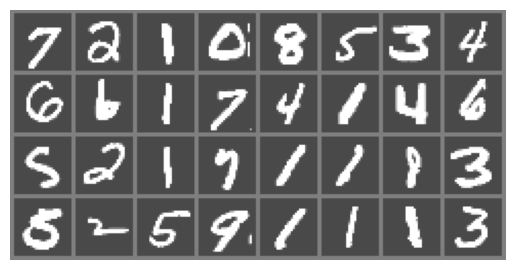

In [29]:
 # You can change the number of images here
 # Get a batch of images
images, labels = next(iter(train_loader))
visualize_mnist_grid(images,  num_rows=8)

In [30]:
def Conv2DTLayer(in_channels, out_channels, kernel_size, stride, padding, act="relu"):
    """
    Create a Convolutional Transpose 2D Layer followed by Batch Normalization and Leaky ReLU activation.

    Args:
        in_channels (int): Number of input channels (i.e., number of feature maps) for the layer.
        out_channels (int): Number of output channels (i.e., number of feature maps) for the layer.
        kernel_size (int or tuple): Size of the convolutional kernel. If a single integer is provided, it's treated as a square kernel size.
        stride (int or tuple): Stride of the convolution operation. If a single integer is provided, it's treated as the same stride in both dimensions.
        padding (int or tuple): Padding to be added to the input feature maps.

    Returns:
        nn.Sequential: A sequential PyTorch module consisting of the following layers:
            - ConvTranspose2d: Convolutional Transpose 2D layer with specified parameters.
            - BatchNorm2d: Batch normalization layer applied to the output of the convolution.
            - LeakyReLU: Leaky Rectified Linear Unit activation function.

    Example:
        # Create a Conv2DTLayer with 3 input channels, 64 output channels, a 4x4 kernel, stride of 2, and padding of 1
        conv2d_layer = Conv2DTLayer(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1)
    """
    if act == "tanh":
        layer_list = [
          nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
          nn.Tanh(),
      ]
    else:
      layer_list = [
          nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
          nn.BatchNorm2d(out_channels),
          nn.LeakyReLU(True),
      ]

    # Create a sequential model from the layer list
    seq_model = nn.Sequential(*layer_list)

    return seq_model


In [31]:
class Generator(nn.Module):
    """
    A generative neural network model for image synthesis using transposed convolution layers.

    Parameters:
        nc (int): Number of output channels (e.g., 1 for grayscale, 3 for RGB).
        nz (int): Size of the input noise vector.
        ngf (int): Number of feature maps in the generator's hidden layers.

    Attributes:
        network (nn.Sequential): The generator network architecture composed of transposed convolution layers
                                 followed by batch normalization and ReLU activation functions.

    Methods:
        forward(input): Forward pass through the generator network.

    Example:
        generator = Generator(nc=3, nz=100, ngf=64)
        noise_input = torch.randn(1, 100, 1, 1)  # Input noise tensor
        fake_image = generator(noise_input)  # Generate a fake image
    """

    def __init__(self, nc=1, nz=100, ngf=32):
        """
        Initialize the Generator object with the specified configuration.

        Args:
            nc (int, optional): Number of output channels (default is 1).
            nz (int, optional): Size of the input noise vector (default is 100).
            ngf (int, optional): Number of feature maps in the generator's hidden layers (default is 32).
        """
        super(Generator, self).__init__()


        self.network = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        """
        Perform a forward pass through the generator network.

        Args:
            input (torch.Tensor): Input noise tensor of shape (batch_size, nz, 1, 1).

        Returns:
            torch.Tensor: Generated fake image tensor of shape (batch_size, nc, H, W).
        """
        out = self.network(input)
        return out


In [32]:
netG = Generator()
netG = netG.to(device)

In [33]:
def getNoise(size=(nz, 1, 1)):
  return torch.randn(BS, 100,1 ,1).to(device)

sample_noise = getNoise()
sample_noise.shape

torch.Size([256, 100, 1, 1])

In [34]:
from torchsummary import summary
base_model = netG.to(device)
summary(netG, input_size=(sample_noise[0].shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 128, 4, 4]         204,800
       BatchNorm2d-2            [-1, 128, 4, 4]             256
              ReLU-3            [-1, 128, 4, 4]               0
   ConvTranspose2d-4             [-1, 64, 7, 7]          73,728
       BatchNorm2d-5             [-1, 64, 7, 7]             128
              ReLU-6             [-1, 64, 7, 7]               0
   ConvTranspose2d-7           [-1, 32, 14, 14]          32,768
       BatchNorm2d-8           [-1, 32, 14, 14]              64
              ReLU-9           [-1, 32, 14, 14]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]             512
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 312,256
Trainable params: 312,256
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [35]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import math
import itertools
import imageio
import natsort
from glob import glob

def generate_images(epoch, path, fixed_noise, netG, device):

    num_test_samples = 16
    # Calculate the number of rows and columns for the grid of generated images
    size_figure_grid = int(math.sqrt(num_test_samples))

    # Initialize the title variable
    title = None

    netG.eval()

    generated_fake_images = netG(fixed_noise)
    title = 'DCGAN'


    # Create the directory if it does not exist
    os.makedirs(path, exist_ok=True)

    # Create a figure and axis for displaying the generated images
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))

    # Remove axis labels for all subplots
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    cnt = 0
    for k in range(num_test_samples):
        i = k // size_figure_grid  # Calculate row index
        j = k % size_figure_grid   # Calculate column index
        cnt += 1

        # Clear the current axis and display the generated image
        ax[i, j].cla()
        ax[i, j].imshow(generated_fake_images[k].data.cpu().numpy().reshape(28, 28), cmap='Greys')

    # Set the label for the figure
    label = 'Epoch_{}'.format(epoch + 1)
    fig.text(0.5, 0.04, label, ha='center')  # Add label at the bottom
    fig.suptitle(title)  # Set the title for the entire figure

    # Save the figure with a label as a PNG file
    fig.savefig(path + label + '.png')

def save_gif(path, fps):

    images = glob(path + '*.png')
    images = natsort.natsorted(images)
    gif = []

    for image in images:
        gif.append(imageio.imread(image))

    imageio.mimsave(path+'animated.gif', gif, fps=fps)


In [36]:
class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=32):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(

                nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout(0.3),

                nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout(0.3),

                nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout(0.3),

                nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
                nn.Sigmoid()
            )
    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(1)

In [37]:
criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()


In [38]:
epochs, noise_dim = 100, 100
epochs, BS, noise_dim

(100, 256, 100)

In [39]:
fixed_noise = getNoise()
path = "./gifs/"


Epoch [1/100]..........	d_loss: 0.0644, g_loss: 4.7867

Epoch [2/100]..........	d_loss: 0.0265, g_loss: 5.5033

Epoch [3/100]..........	d_loss: 0.0188, g_loss: 5.7108

Epoch [4/100]..........	d_loss: 0.0092, g_loss: 6.1044

Epoch [5/100]..........	d_loss: 0.0164, g_loss: 5.7434


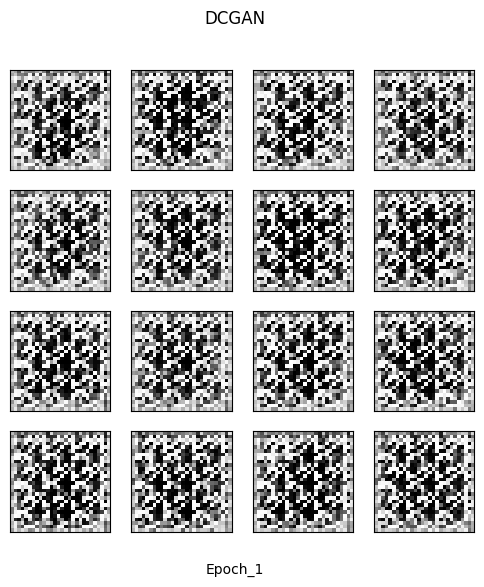

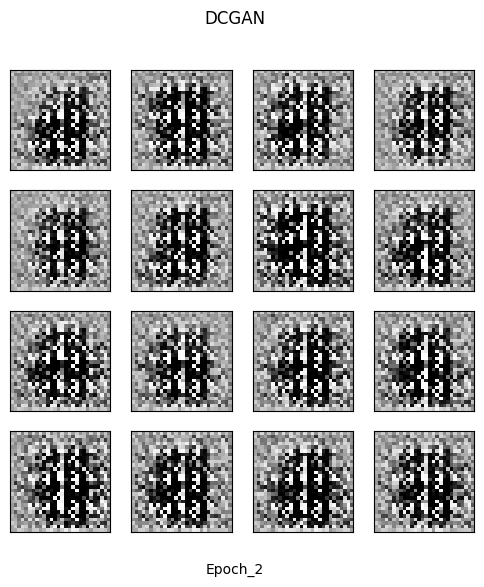

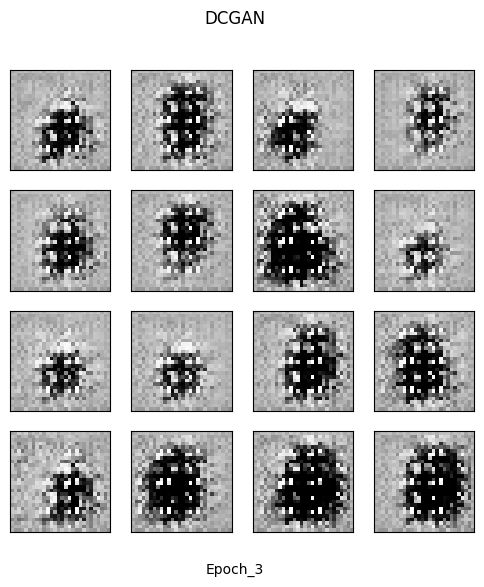

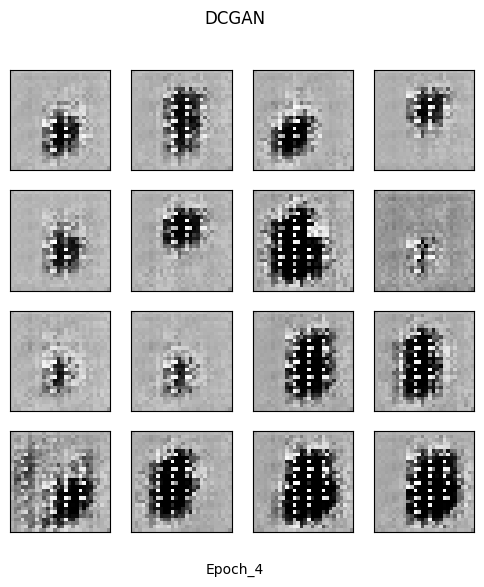

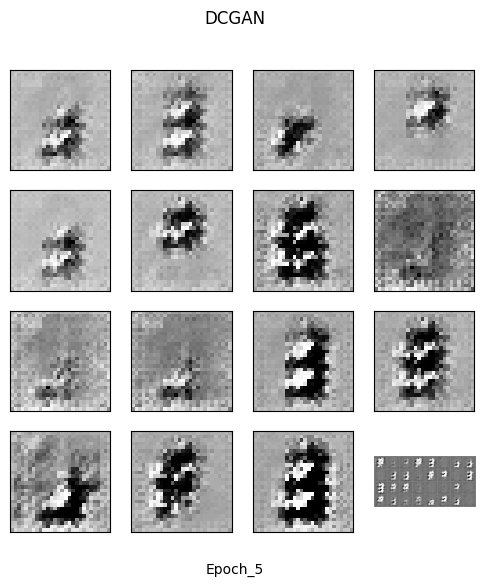


Epoch [6/100]..........	d_loss: 0.0062, g_loss: 6.2216

Epoch [7/100]..........	d_loss: 0.0156, g_loss: 5.9820

Epoch [8/100]..........	d_loss: 0.0101, g_loss: 6.0831

Epoch [9/100]..........	d_loss: 0.0030, g_loss: 6.9627

Epoch [10/100]..........	d_loss: 0.0039, g_loss: 7.8277


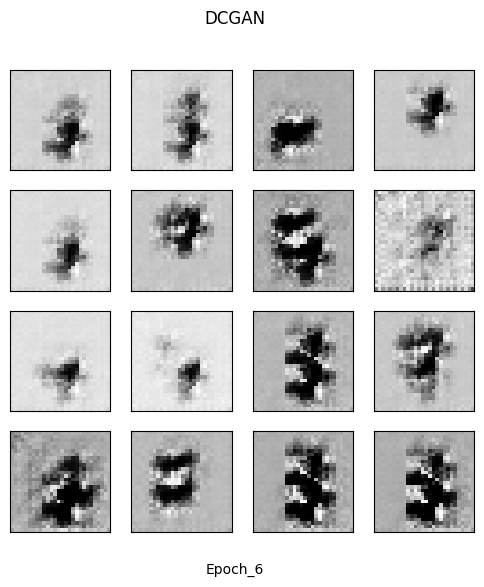

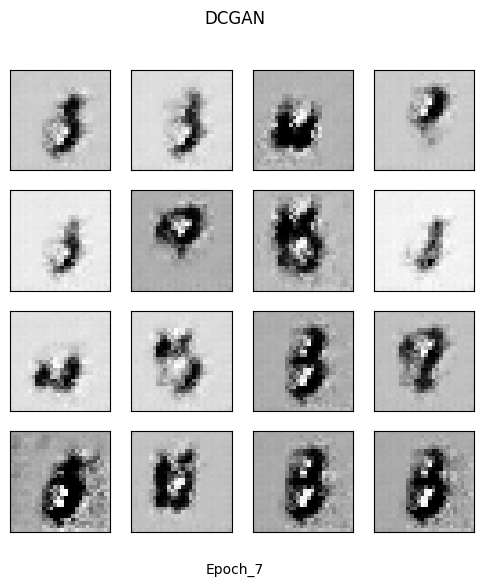

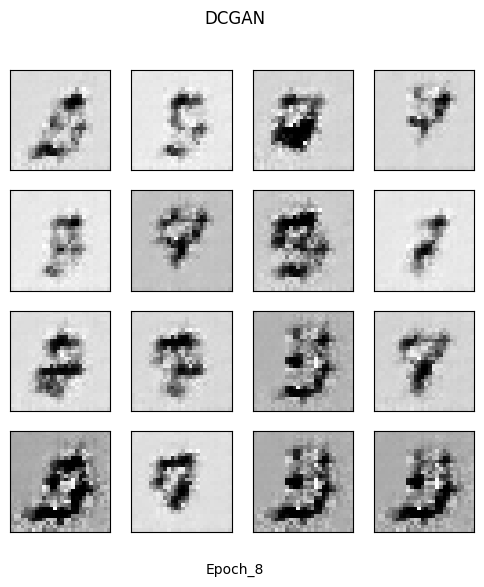

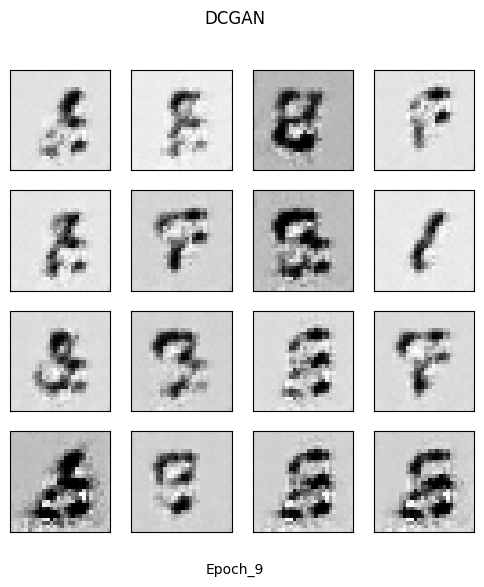

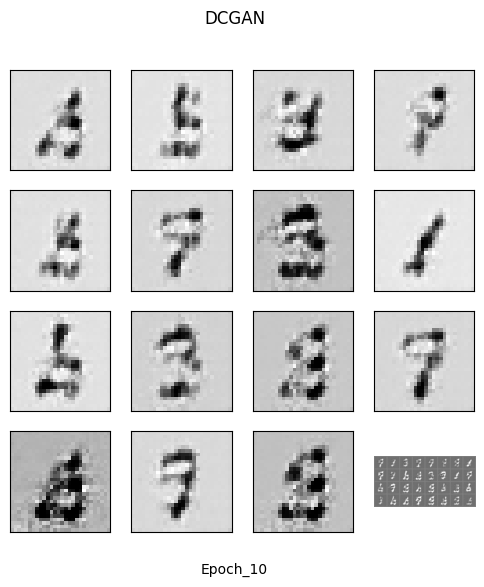


Epoch [11/100]..........	d_loss: 0.0023, g_loss: 7.3935

Epoch [12/100]..........	d_loss: 0.0029, g_loss: 7.9269

Epoch [13/100]..........	d_loss: 0.0038, g_loss: 7.2430

Epoch [14/100]..........	d_loss: 0.0037, g_loss: 8.7749

Epoch [15/100]..........	d_loss: 0.0010, g_loss: 7.3693


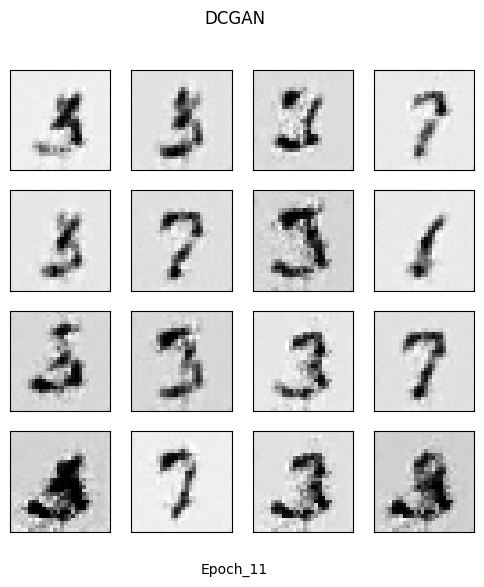

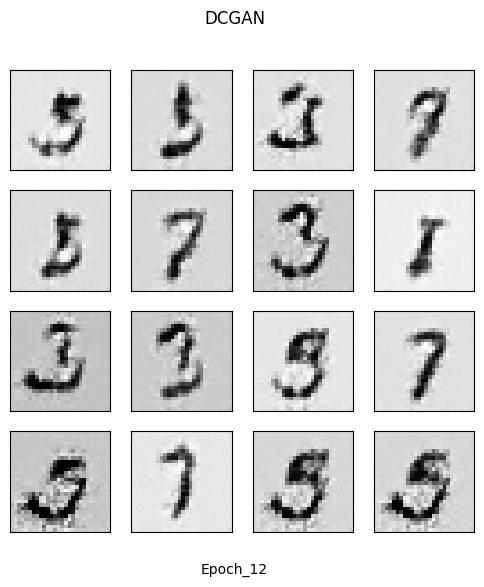

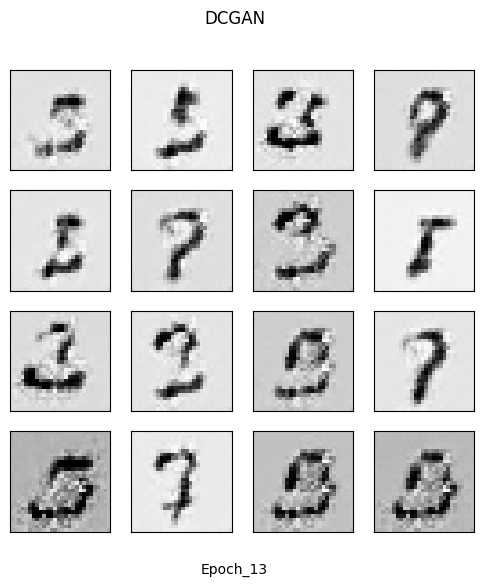

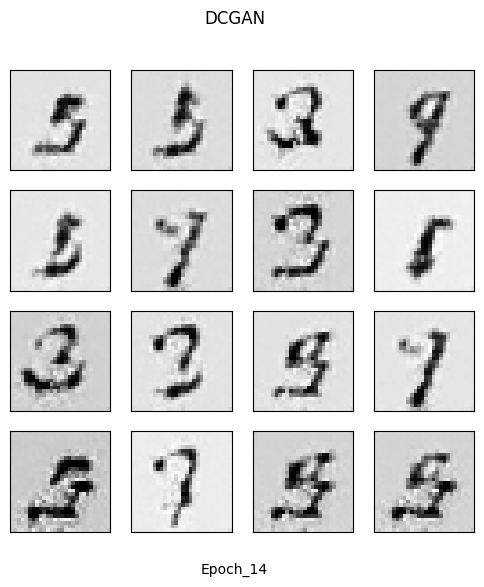

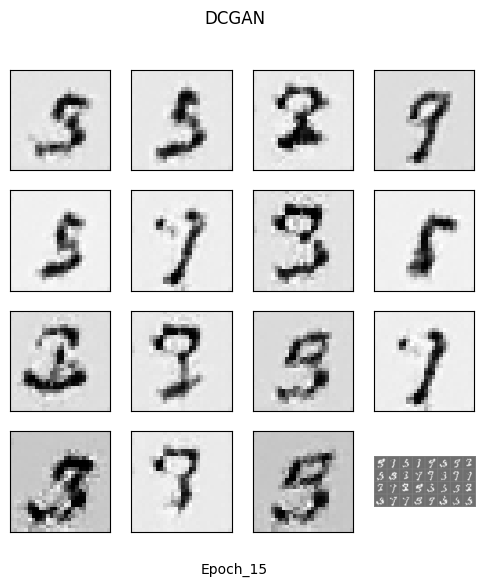


Epoch [16/100]..........	d_loss: 0.0021, g_loss: 8.1534

Epoch [17/100]..........	d_loss: 0.0034, g_loss: 7.5714

Epoch [18/100]..........	d_loss: 0.0031, g_loss: 7.3241

Epoch [19/100]..........	d_loss: 0.0022, g_loss: 7.5925

Epoch [20/100]..........	d_loss: 0.0039, g_loss: 9.1018


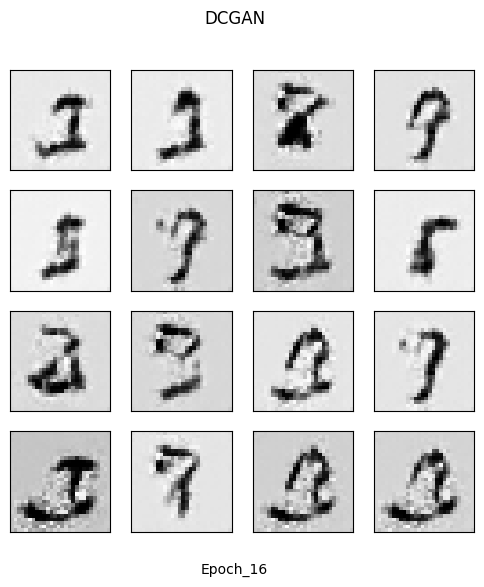

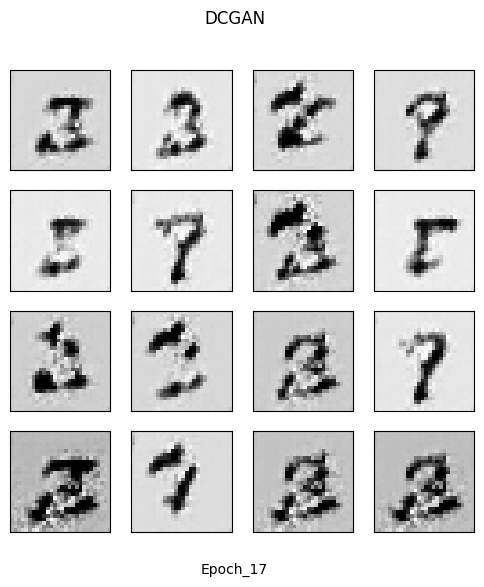

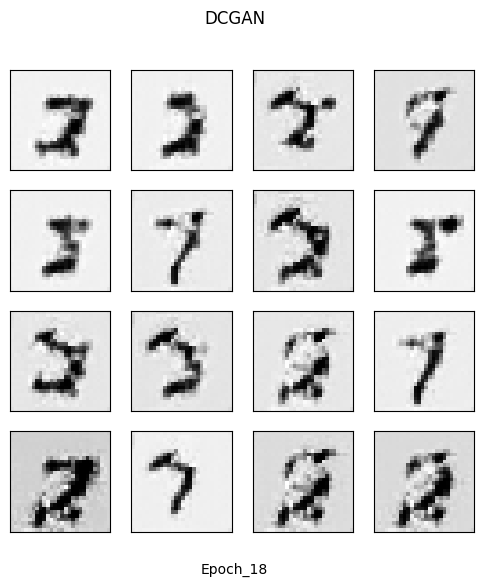

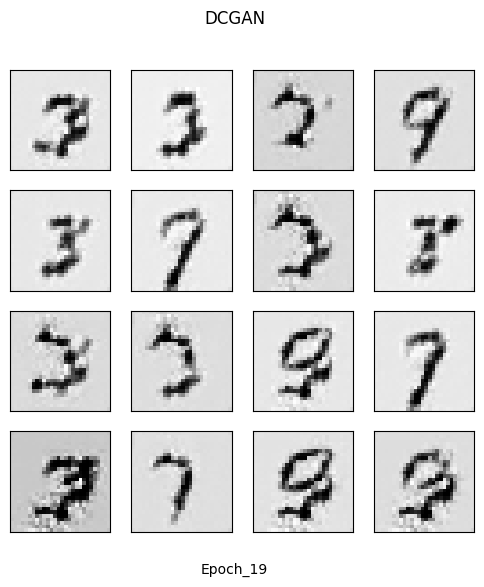

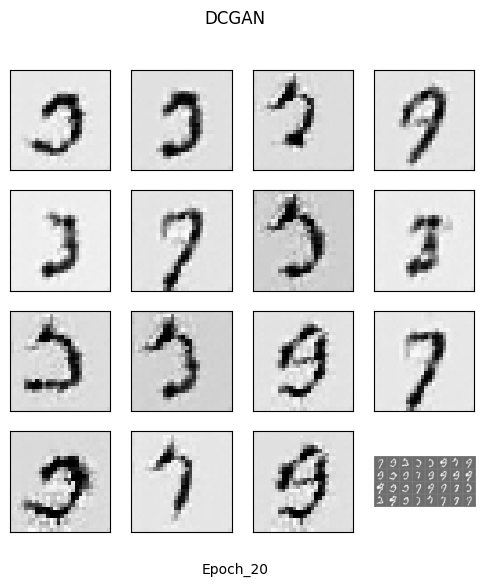


Epoch [21/100]..........	d_loss: 0.0038, g_loss: 6.9975

Epoch [22/100]..........	d_loss: 0.0015, g_loss: 7.9959

Epoch [23/100]..........	d_loss: 0.0008, g_loss: 8.1836

Epoch [24/100]..........	d_loss: 0.0037, g_loss: 6.9275

Epoch [25/100]..........	d_loss: 0.0008, g_loss: 7.8866


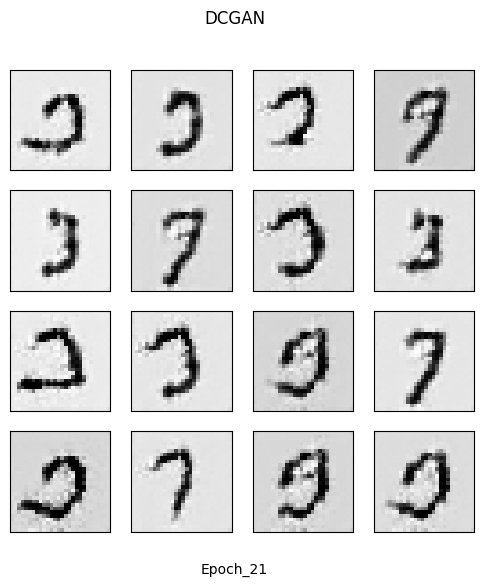

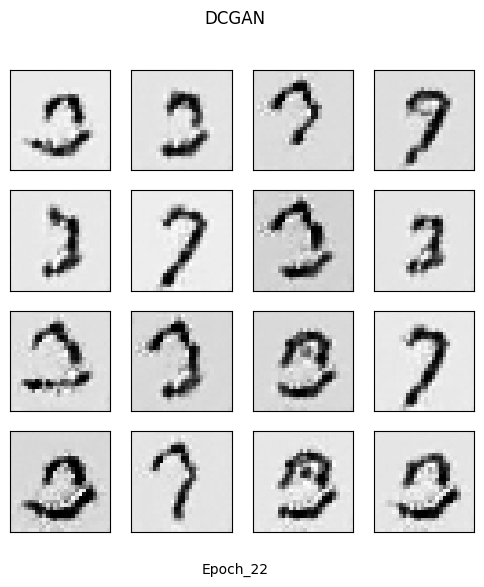

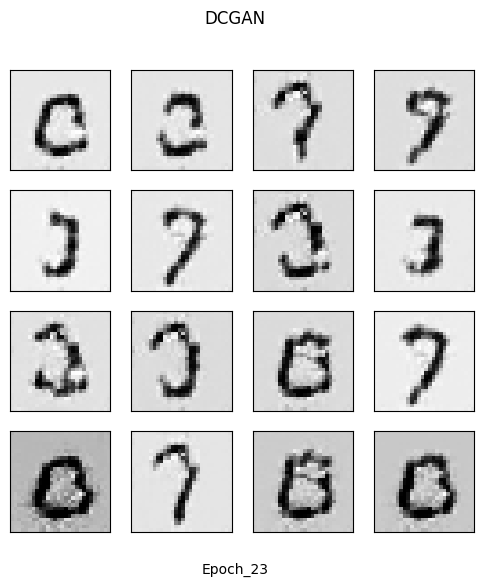

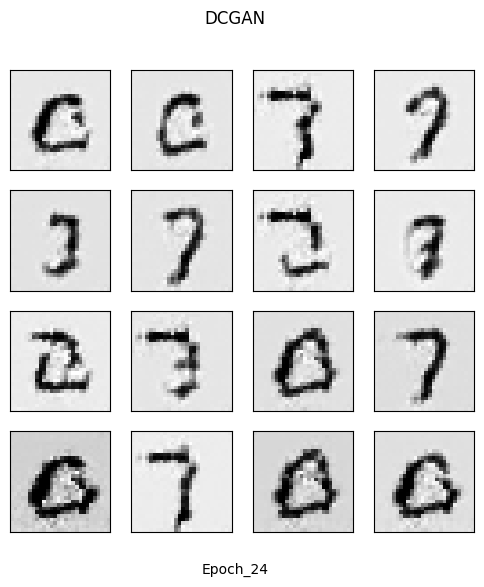

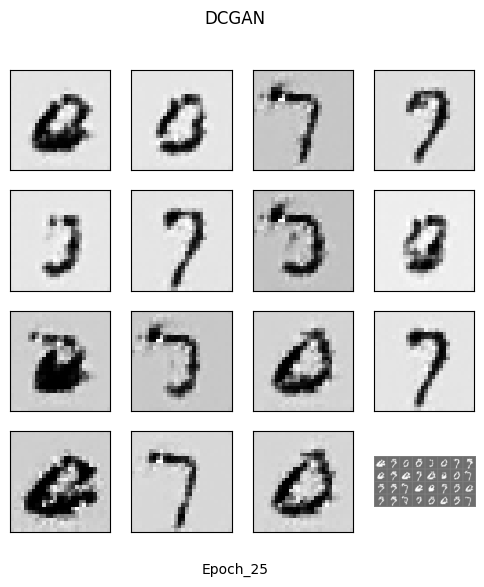


Epoch [26/100]..........	d_loss: 0.0020, g_loss: 7.6382

Epoch [27/100]..........	d_loss: 0.0008, g_loss: 7.9073

Epoch [28/100]..........	d_loss: 0.0018, g_loss: 9.0909

Epoch [29/100]..........	d_loss: 0.0037, g_loss: 7.7172

Epoch [30/100]..........	d_loss: 0.0047, g_loss: 7.9442


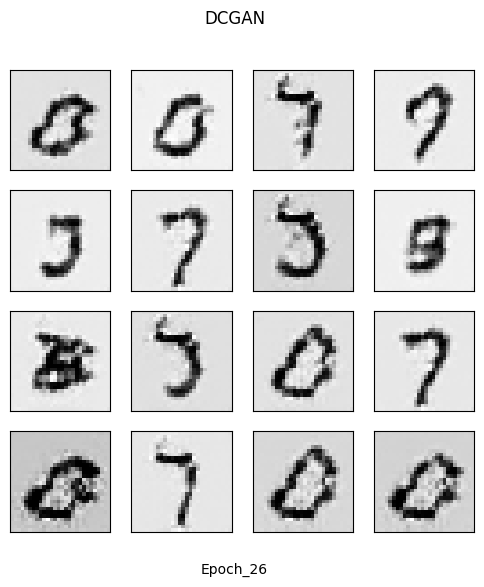

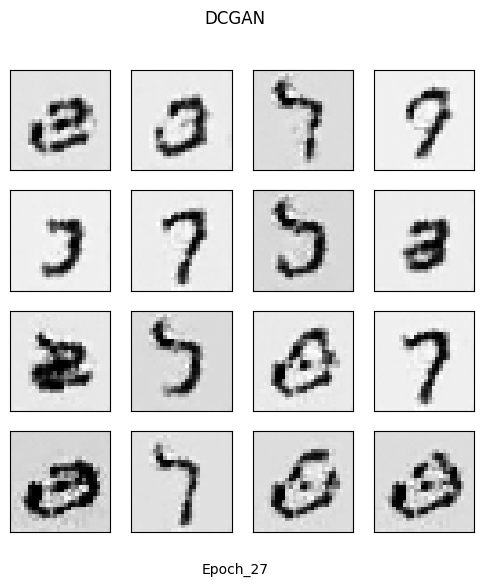

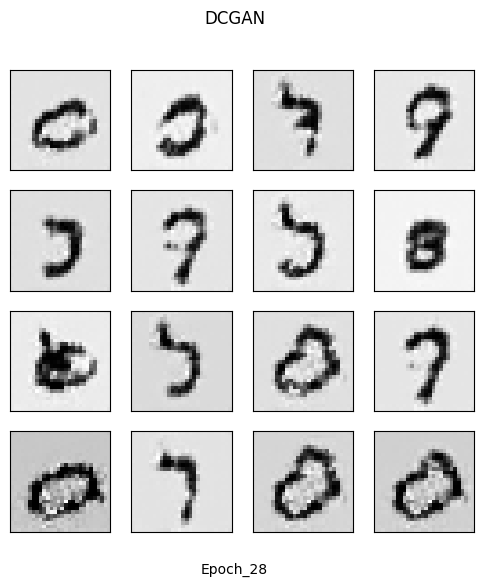

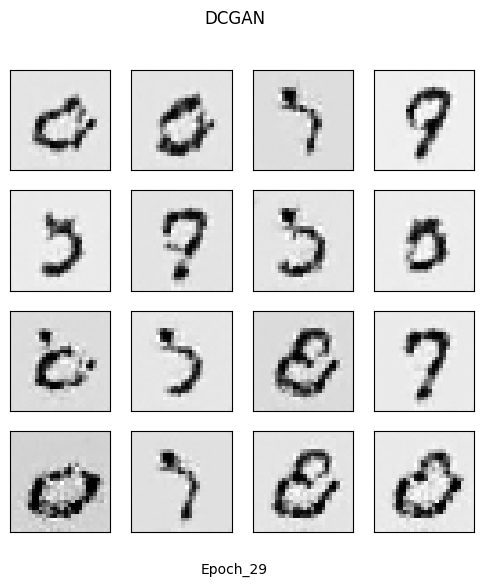

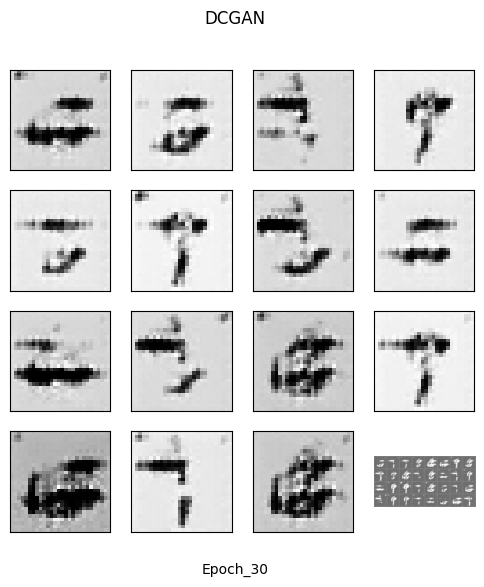


Epoch [31/100]..........	d_loss: 0.0112, g_loss: 5.3621

Epoch [32/100]..........	d_loss: 0.0088, g_loss: 5.8781

Epoch [33/100]..........	d_loss: 0.0070, g_loss: 6.4886

Epoch [34/100]..........	d_loss: 0.0137, g_loss: 5.7024

Epoch [35/100]..........	d_loss: 0.0018, g_loss: 8.0544


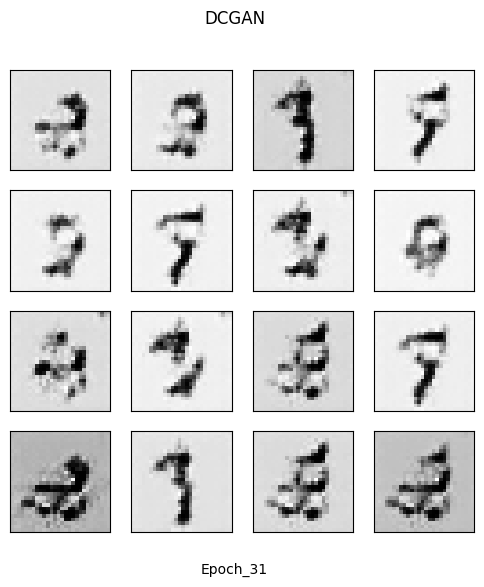

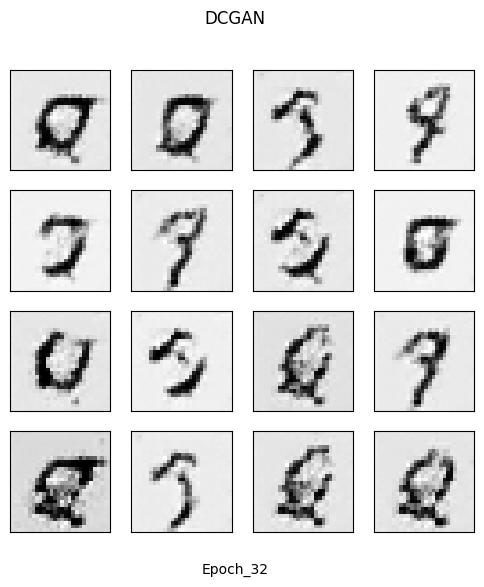

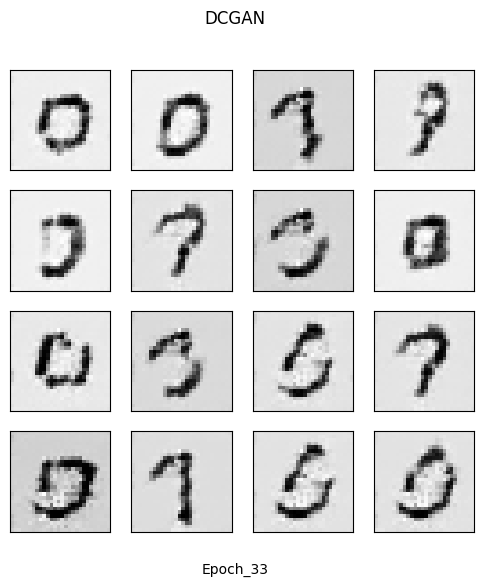

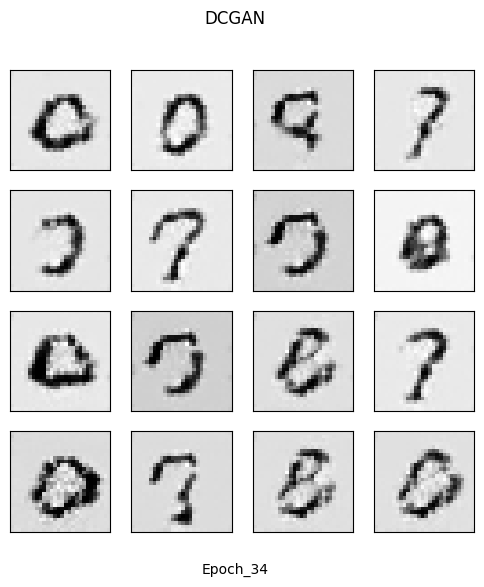

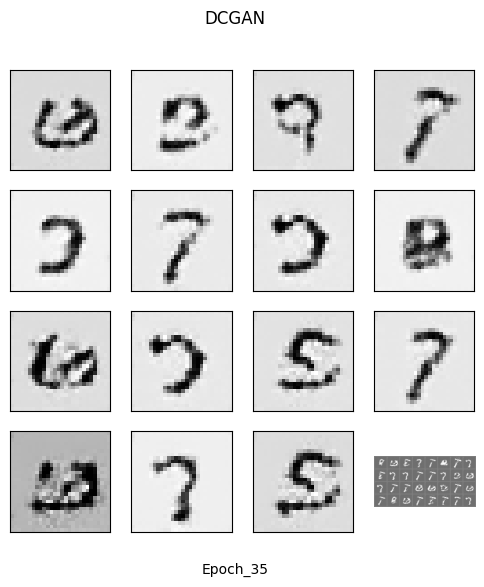


Epoch [36/100]..........	d_loss: 0.0063, g_loss: 7.0472

Epoch [37/100]..........	d_loss: 0.0112, g_loss: 6.4452

Epoch [38/100]..........	d_loss: 0.0074, g_loss: 6.6085

Epoch [39/100]..........	d_loss: 0.0212, g_loss: 7.3609

Epoch [40/100]..........	d_loss: 0.0028, g_loss: 7.8299


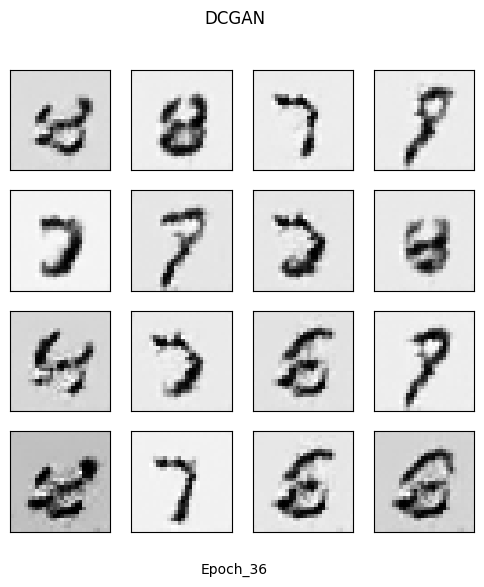

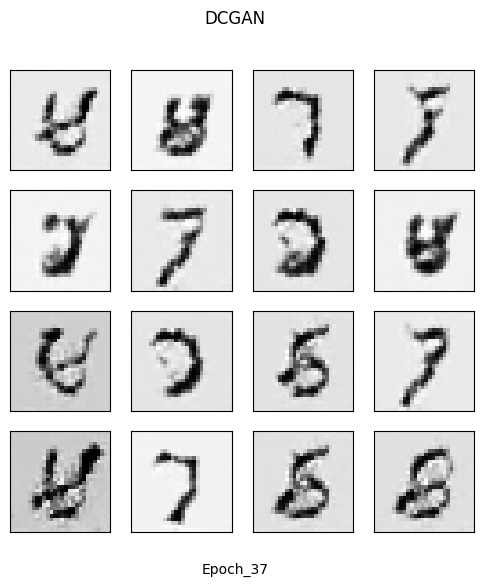

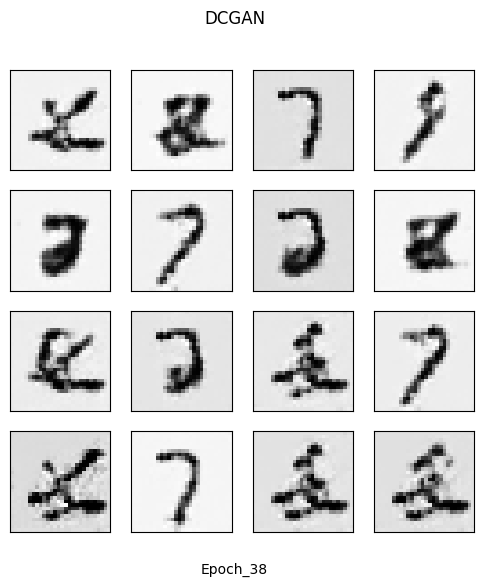

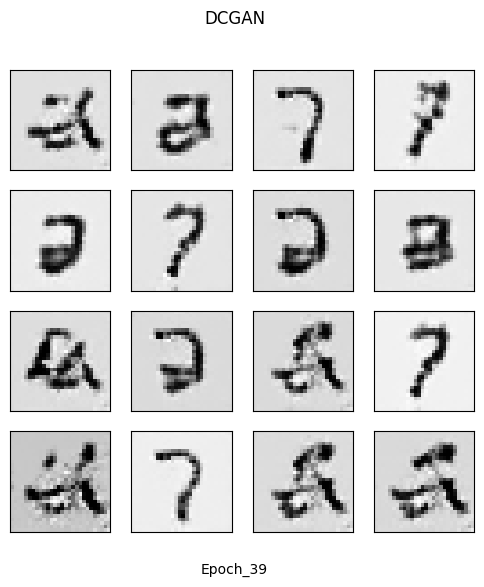

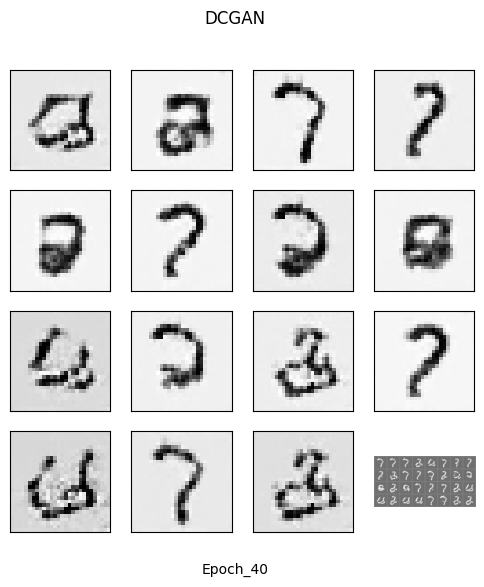


Epoch [41/100]..........	d_loss: 0.0014, g_loss: 8.2104

Epoch [42/100]..........	d_loss: 0.0035, g_loss: 7.9997

Epoch [43/100]..........	d_loss: 0.0912, g_loss: 4.7546

Epoch [44/100]..........	d_loss: 0.0152, g_loss: 6.0226

Epoch [45/100]..........	d_loss: 0.0153, g_loss: 6.8771


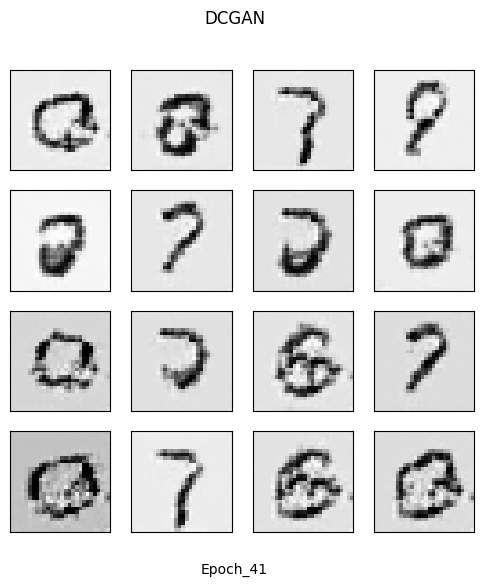

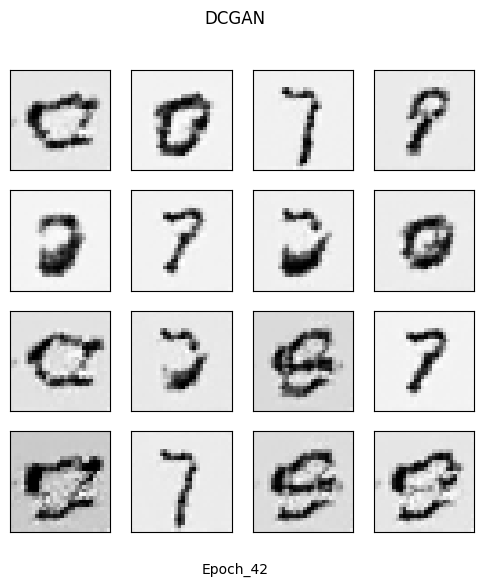

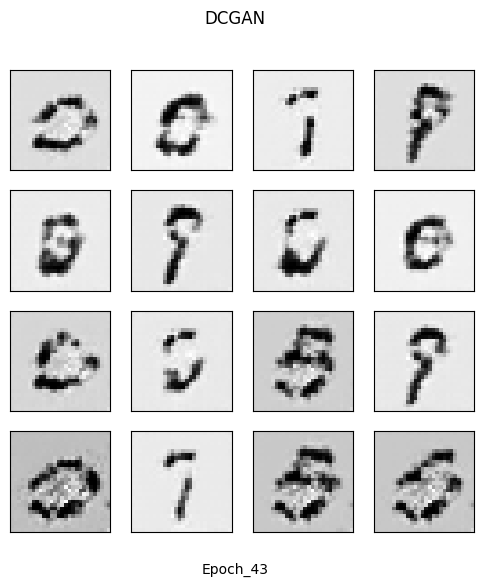

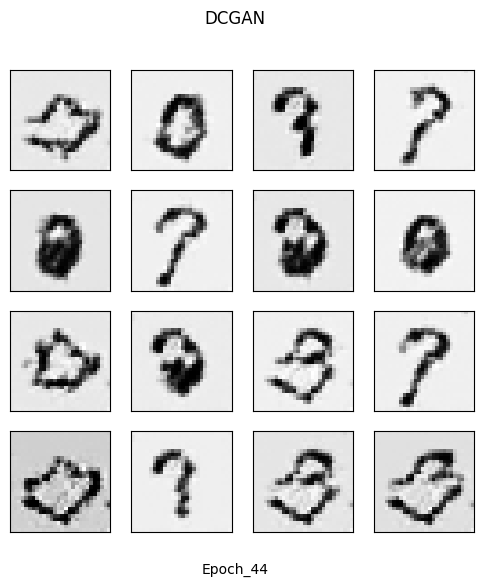

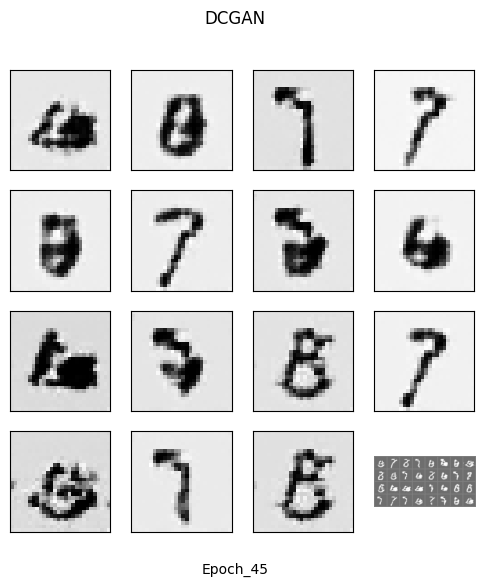


Epoch [46/100]..........	d_loss: 0.0157, g_loss: 5.8003

Epoch [47/100]..........	d_loss: 0.0073, g_loss: 6.1657

Epoch [48/100]..........	d_loss: 0.0072, g_loss: 8.9239

Epoch [49/100]..........	d_loss: 0.0101, g_loss: 5.9035

Epoch [50/100]..........	d_loss: 0.0065, g_loss: 7.3684


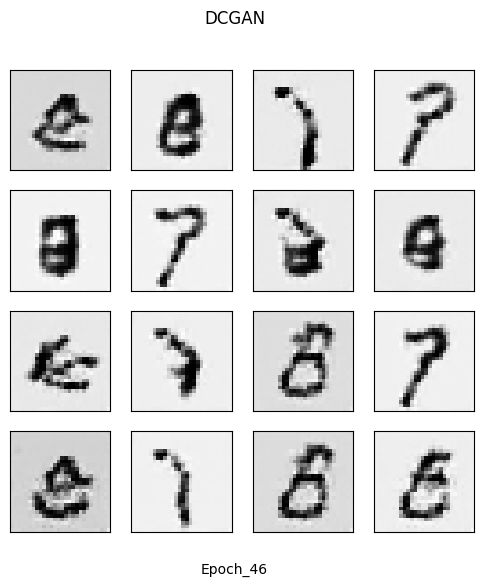

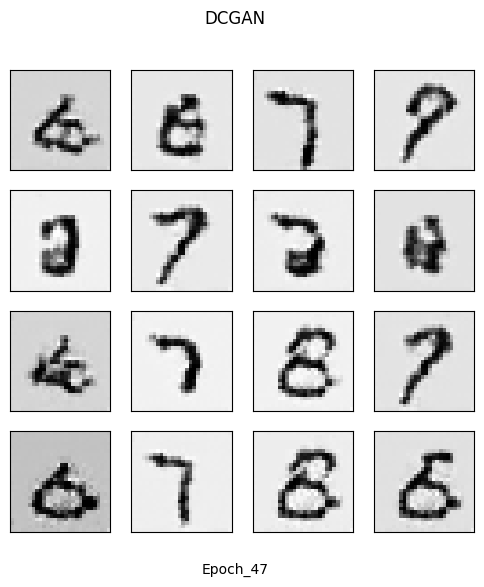

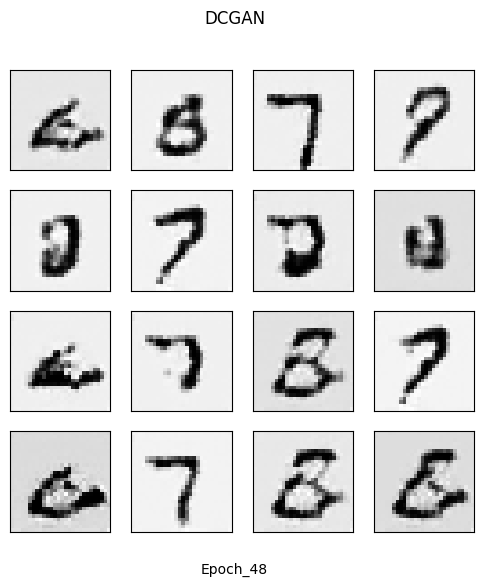

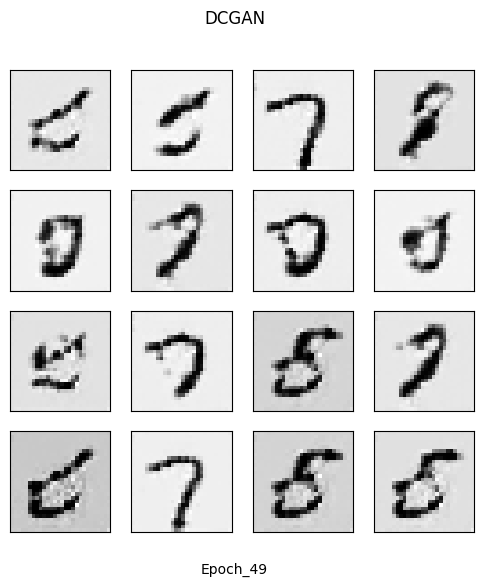

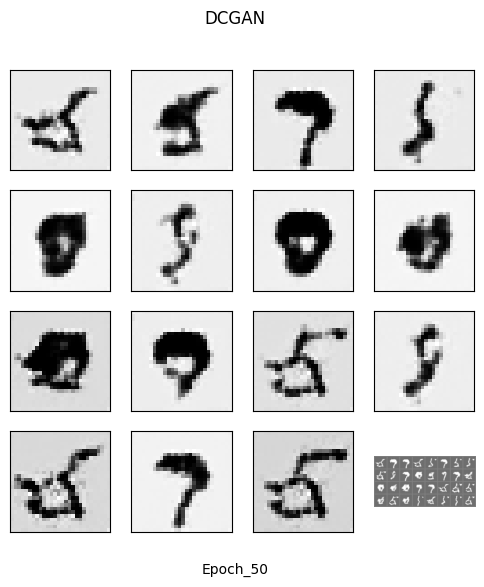


Epoch [51/100]..........	d_loss: 0.0053, g_loss: 6.2627

Epoch [52/100]..........	d_loss: 0.0048, g_loss: 7.8706

Epoch [53/100]..........	d_loss: 0.0006, g_loss: 9.2005

Epoch [54/100]..........	d_loss: 0.0025, g_loss: 8.0163

Epoch [55/100]..........	d_loss: 0.0026, g_loss: 8.0235


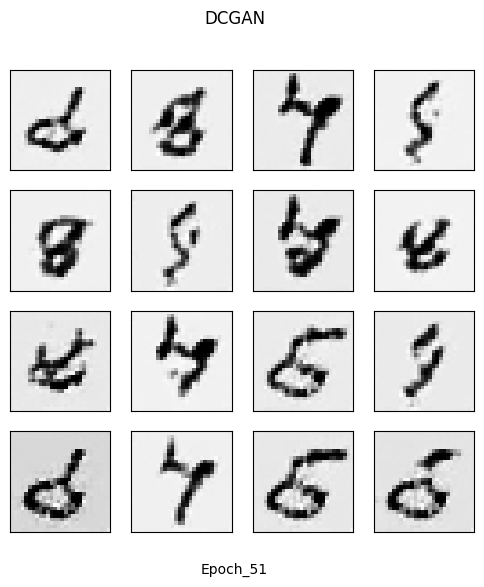

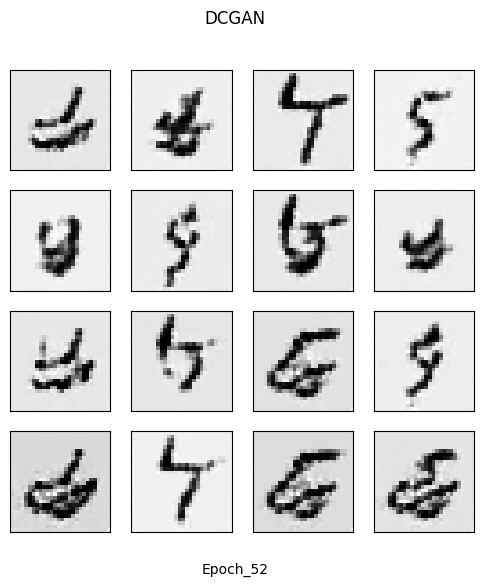

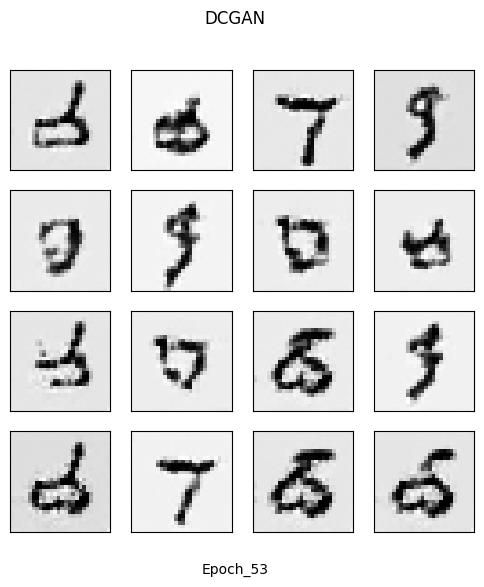

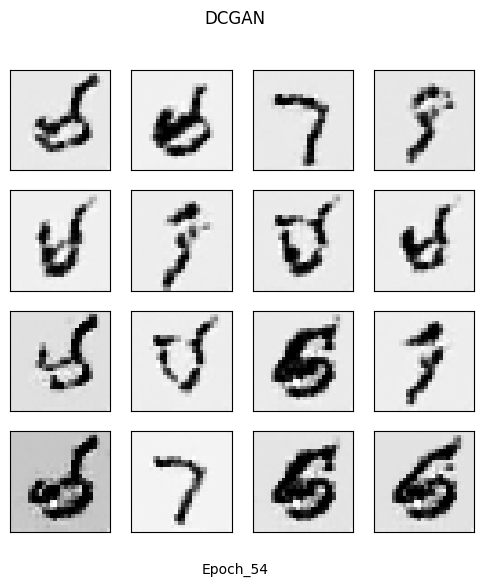

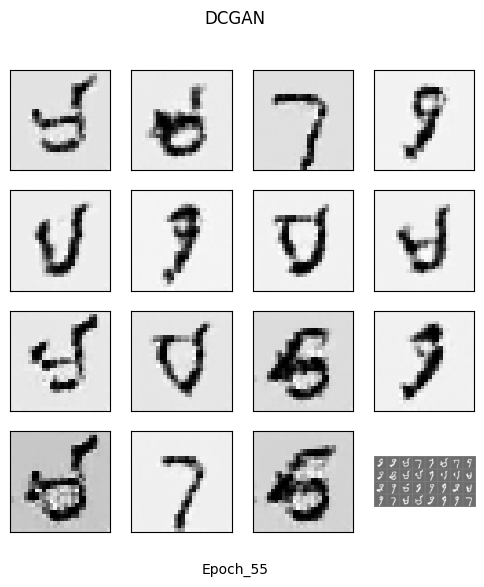


Epoch [56/100]..........	d_loss: 0.0046, g_loss: 7.0642

Epoch [57/100]..........	d_loss: 0.0011, g_loss: 8.4782

Epoch [58/100]..........	d_loss: 0.0002, g_loss: 11.8357

Epoch [59/100]..........	d_loss: 0.0035, g_loss: 7.8836

Epoch [60/100]..........	d_loss: 0.0002, g_loss: 11.6294


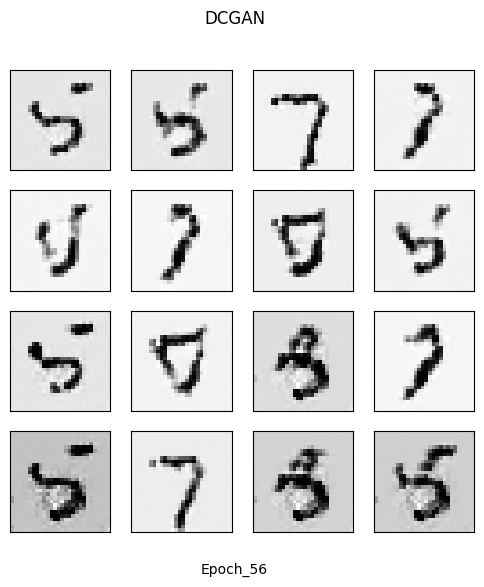

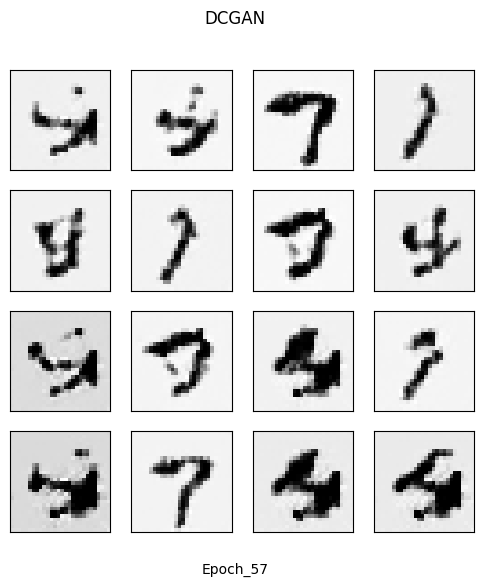

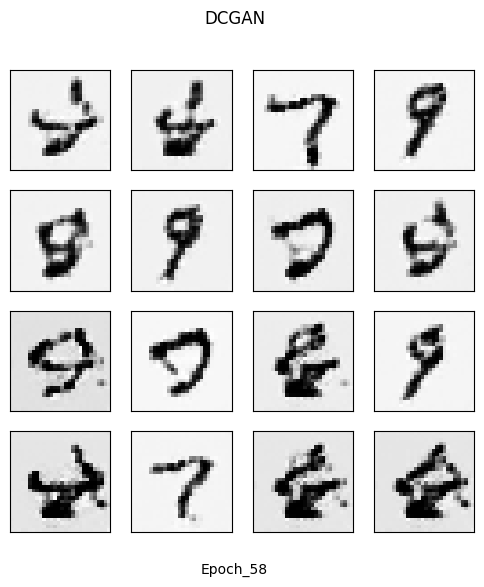

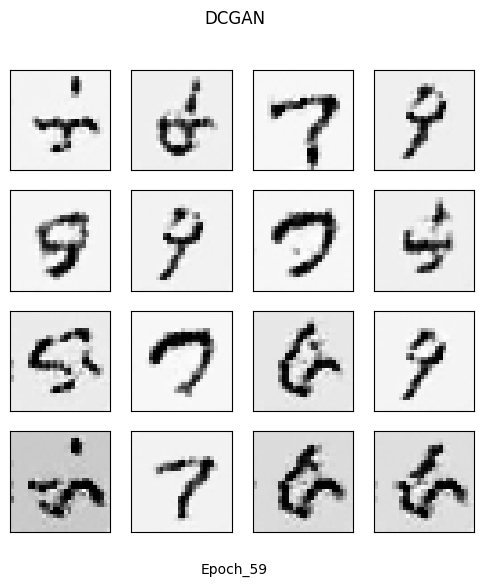

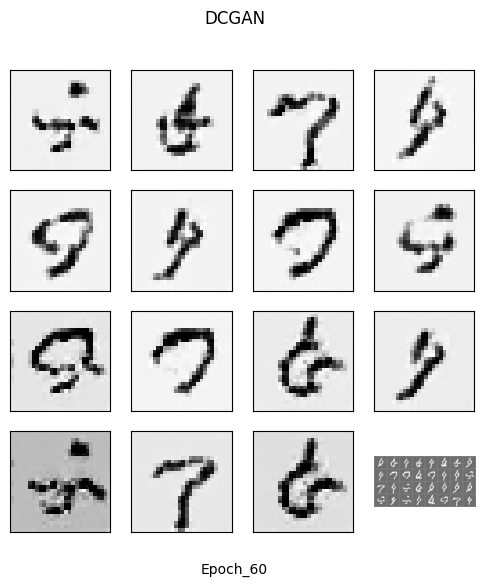


Epoch [61/100]..........	d_loss: 0.0017, g_loss: 7.9337

Epoch [62/100]..........	d_loss: 0.0009, g_loss: 10.2703

Epoch [63/100]..........	d_loss: 0.0024, g_loss: 7.6563

Epoch [64/100]..........	d_loss: 0.0010, g_loss: 8.1891

Epoch [65/100]..........	d_loss: 0.0008, g_loss: 9.5394


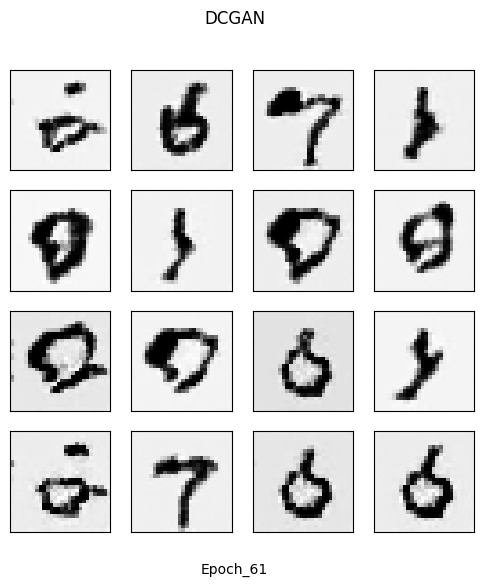

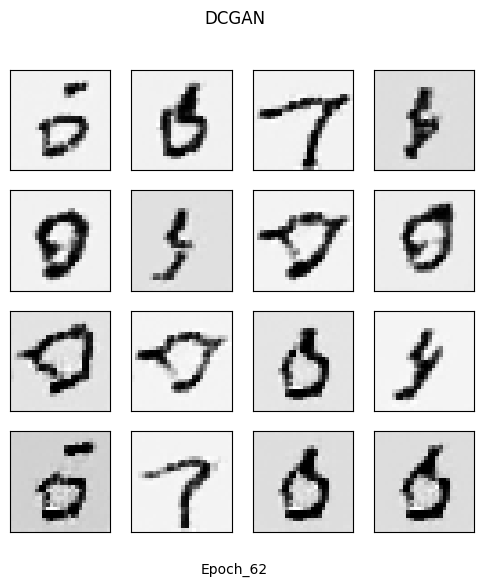

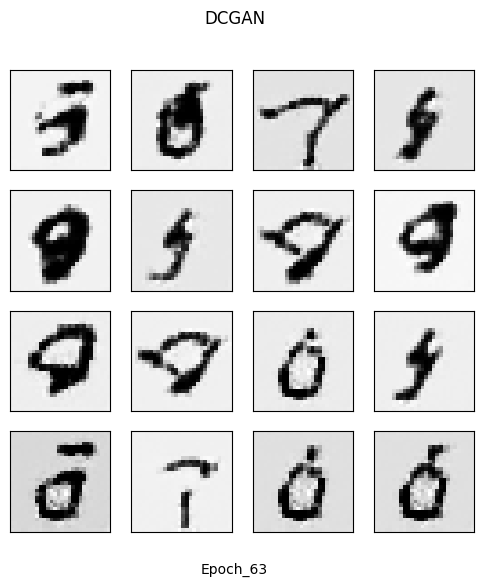

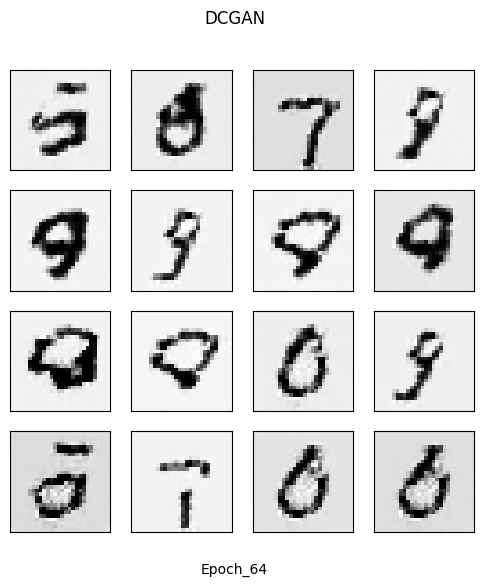

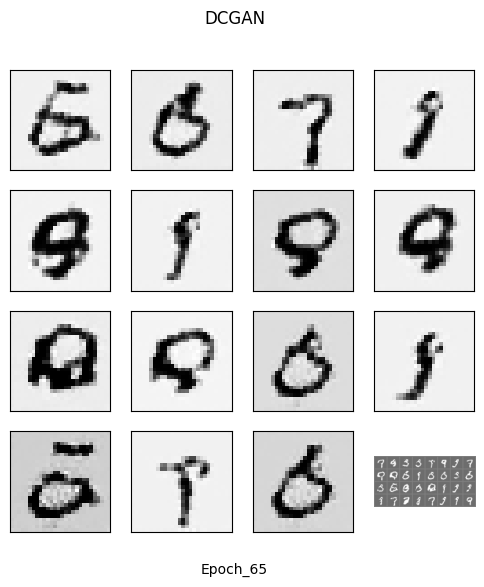


Epoch [66/100]..........	d_loss: 0.0471, g_loss: 5.7673

Epoch [67/100]..........	d_loss: 0.0259, g_loss: 6.1134

Epoch [68/100]..........	d_loss: 0.0075, g_loss: 6.6785

Epoch [69/100]..........	d_loss: 0.0119, g_loss: 5.8704

Epoch [70/100]..........	d_loss: 0.0172, g_loss: 6.0993


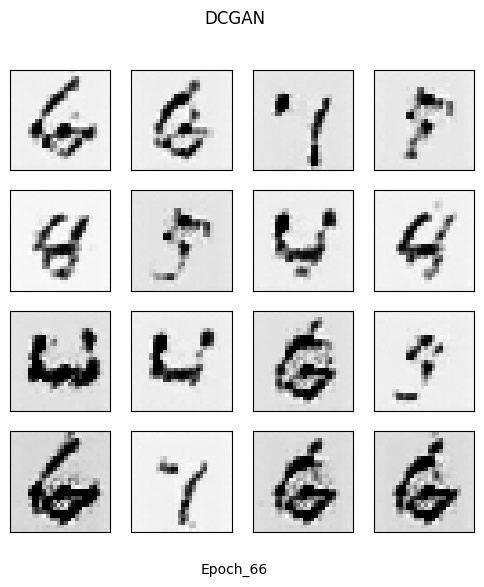

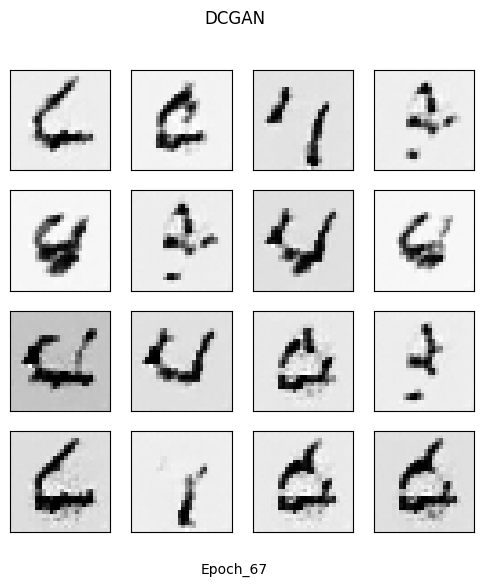

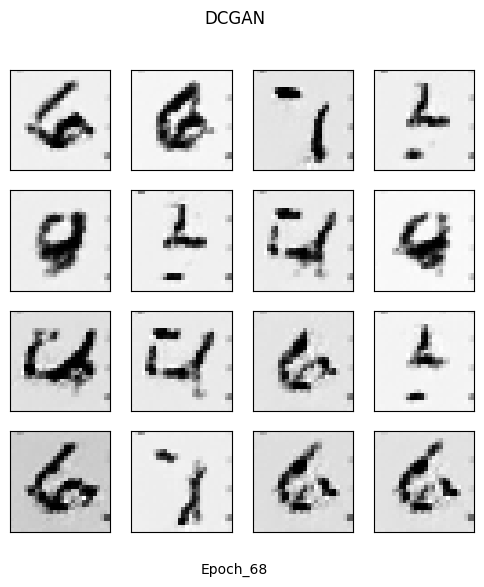

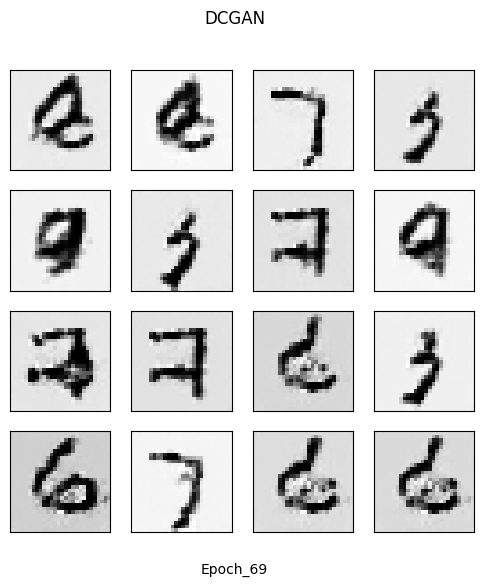

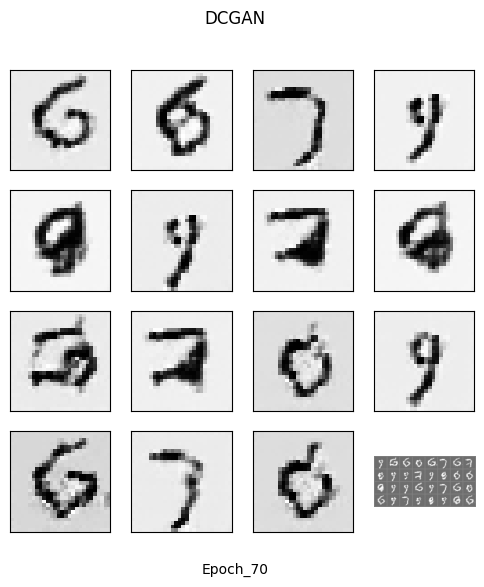


Epoch [71/100]..........	d_loss: 0.0258, g_loss: 5.5803

Epoch [72/100]..........	d_loss: 0.0028, g_loss: 7.2739

Epoch [73/100]..........	d_loss: 0.0026, g_loss: 7.5860

Epoch [74/100]..........	d_loss: 0.0025, g_loss: 7.1087

Epoch [75/100]..........	d_loss: 0.0340, g_loss: 6.3441


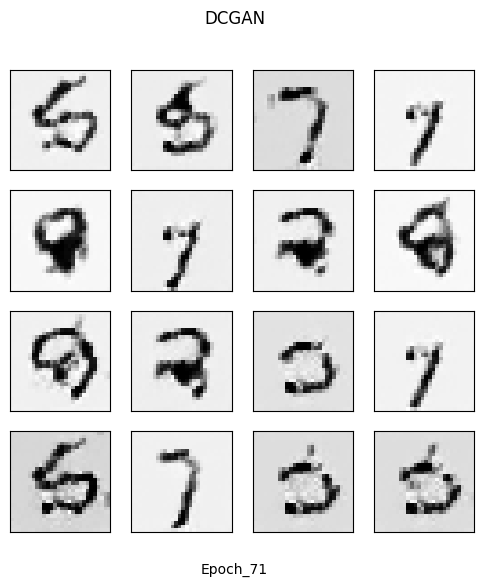

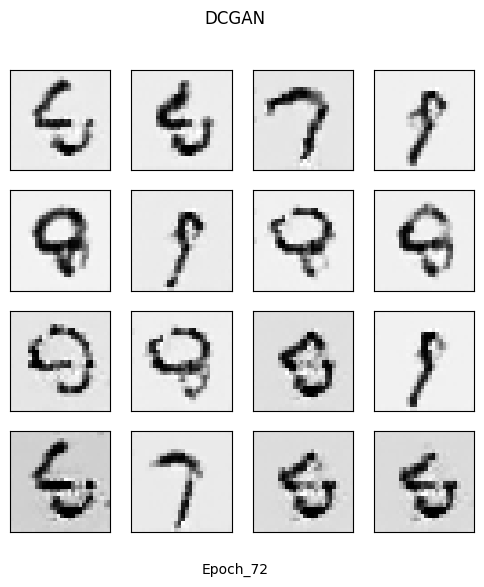

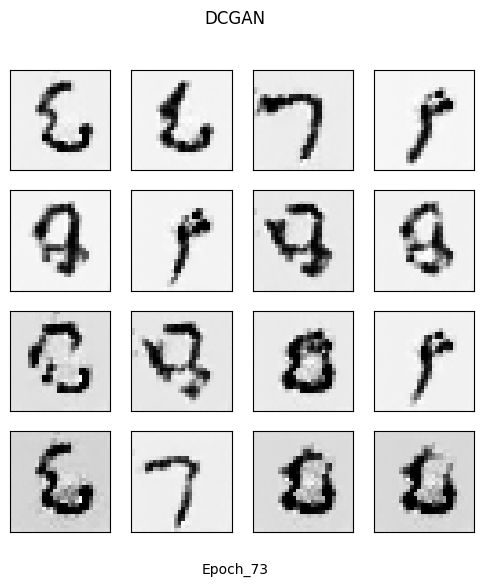

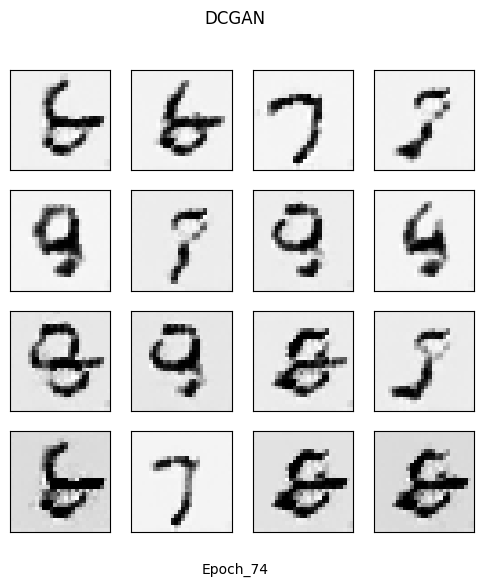

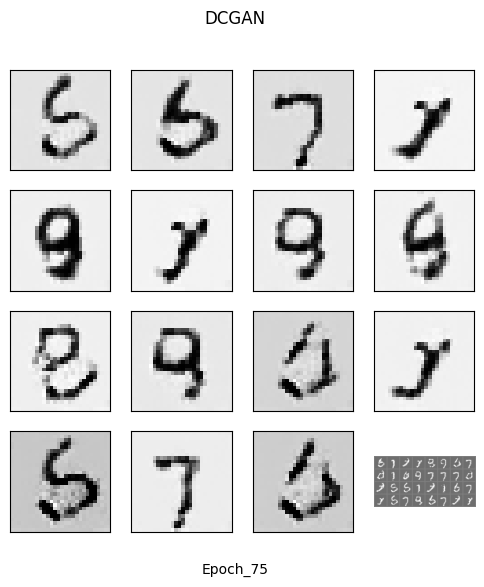


Epoch [76/100]..........	d_loss: 0.0028, g_loss: 7.3676

Epoch [77/100]..........	d_loss: 0.0052, g_loss: 6.5938

Epoch [78/100]..........	d_loss: 0.0036, g_loss: 7.6931

Epoch [79/100]..........	d_loss: 0.0033, g_loss: 7.2476

Epoch [80/100]..........	d_loss: 0.0014, g_loss: 8.2383


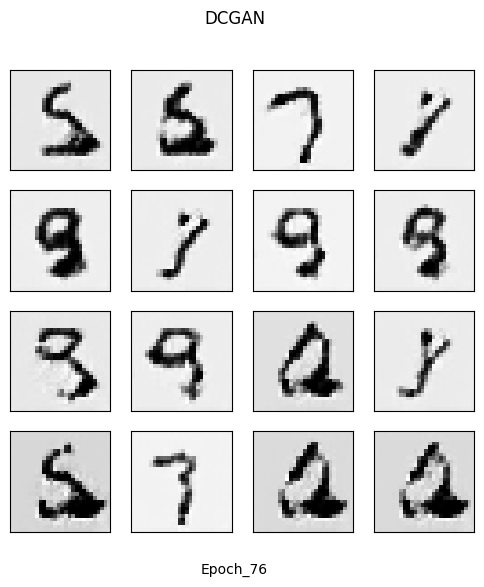

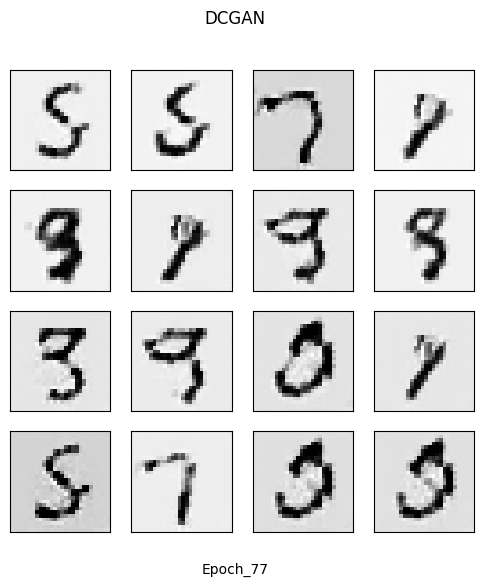

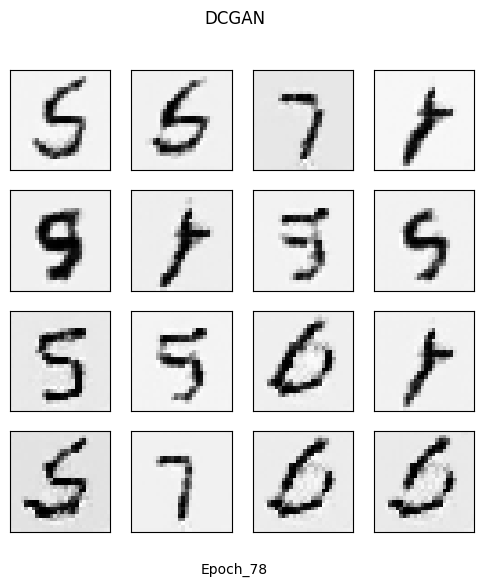

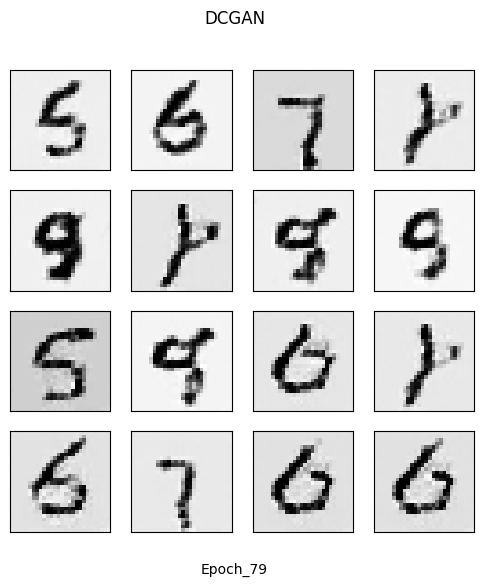

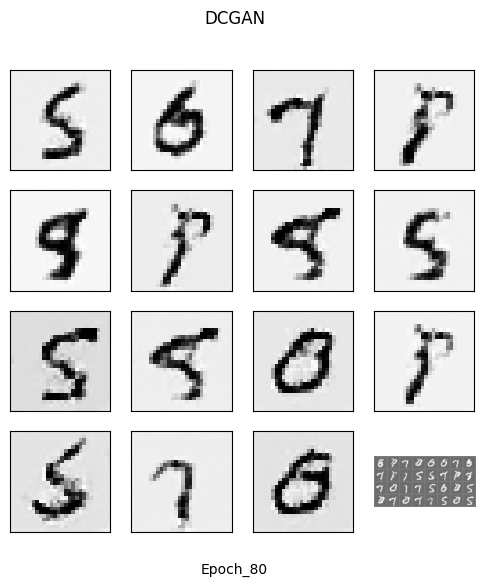


Epoch [81/100]..........	d_loss: 0.0162, g_loss: 8.1775

Epoch [82/100]..........	d_loss: 0.0015, g_loss: 7.8837

Epoch [83/100]..........	d_loss: 0.0012, g_loss: 8.7291

Epoch [84/100]..........	d_loss: 0.0024, g_loss: 9.1300

Epoch [85/100]..........	d_loss: 0.0065, g_loss: 7.0701


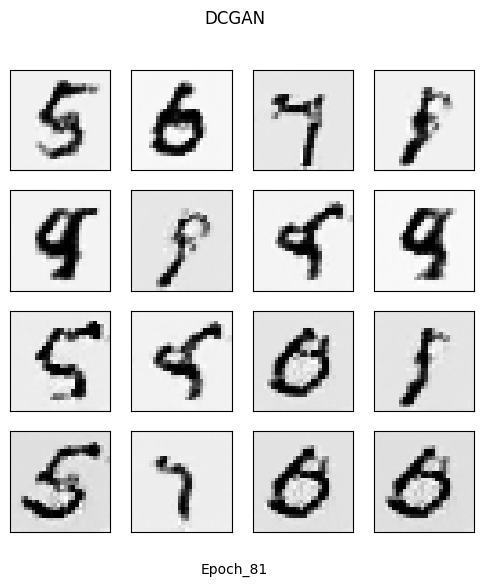

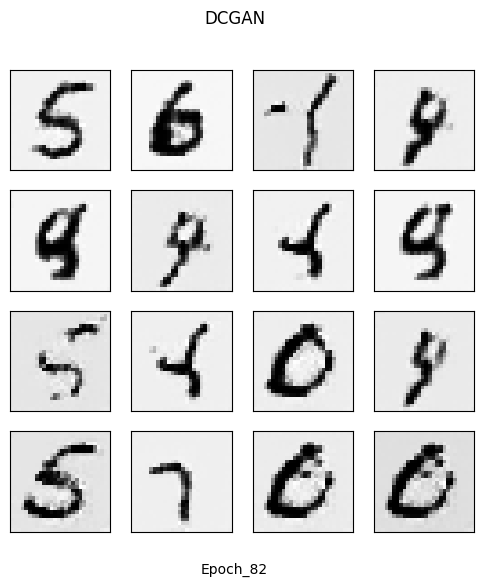

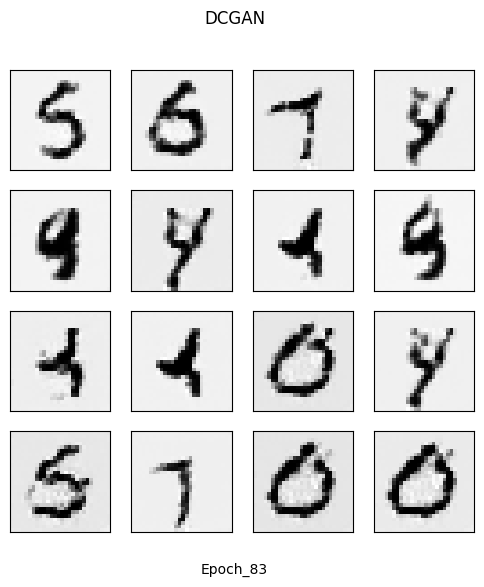

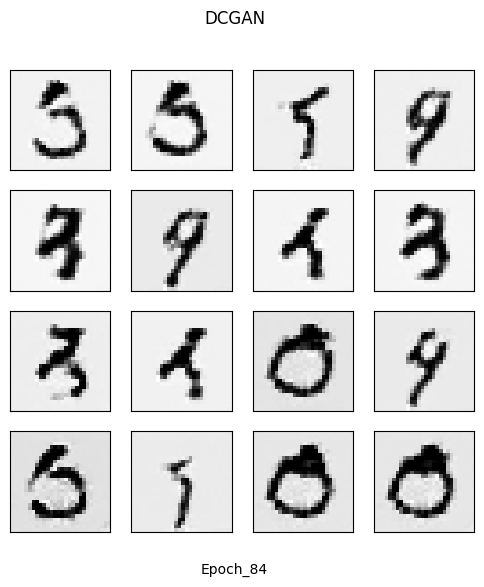

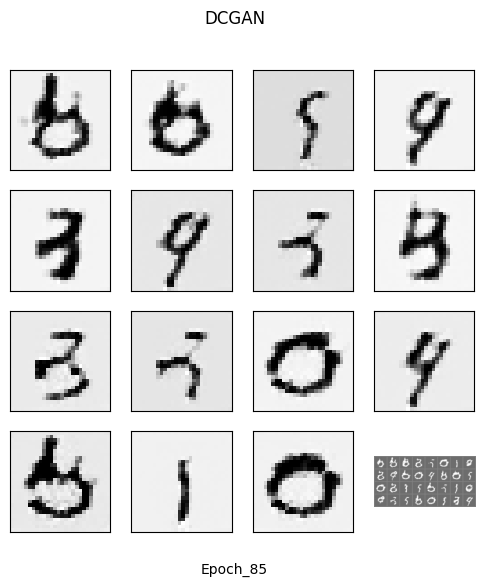


Epoch [86/100]..........	d_loss: 0.0087, g_loss: 7.6256

Epoch [87/100]..........	d_loss: 0.0031, g_loss: 11.7653

Epoch [88/100]..........	d_loss: 0.0015, g_loss: 8.4785

Epoch [89/100]..........	d_loss: 0.0078, g_loss: 8.5149

Epoch [90/100]..........	d_loss: 0.0108, g_loss: 7.3592


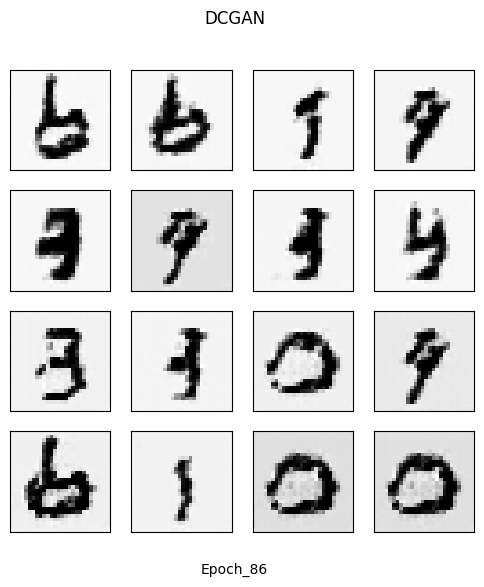

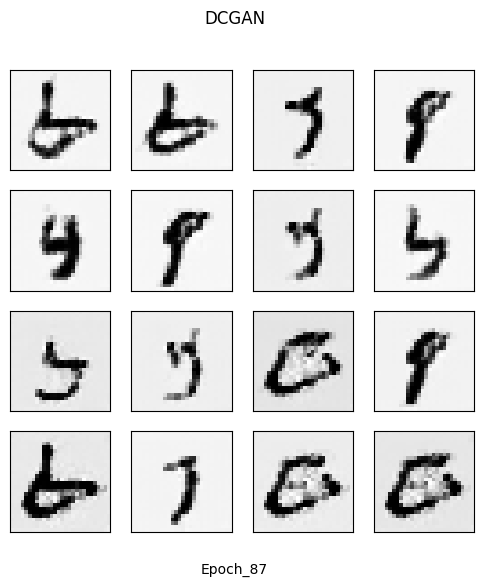

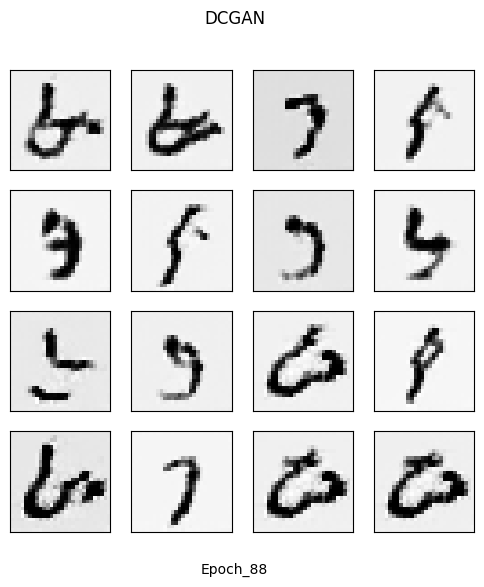

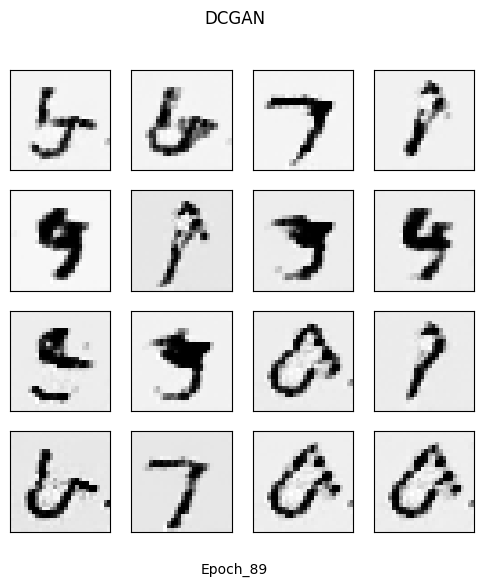

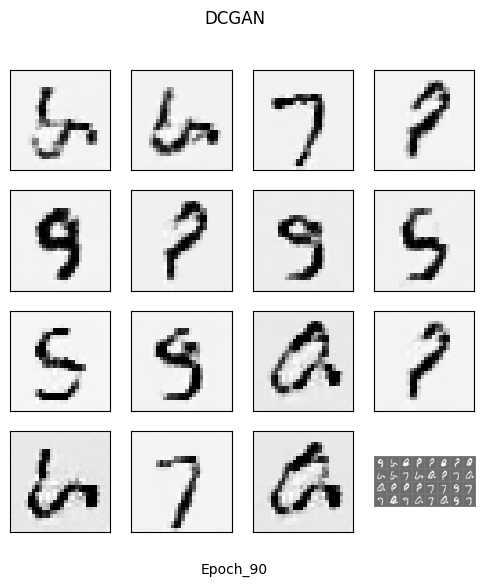


Epoch [91/100]..........	d_loss: 0.0042, g_loss: 8.3394

Epoch [92/100]..........	d_loss: 0.0017, g_loss: 7.7777

Epoch [93/100]..........	d_loss: 0.0012, g_loss: 7.9471

Epoch [94/100]..........	d_loss: 0.0016, g_loss: 8.4362

Epoch [95/100]..........	d_loss: 0.0016, g_loss: 9.3116


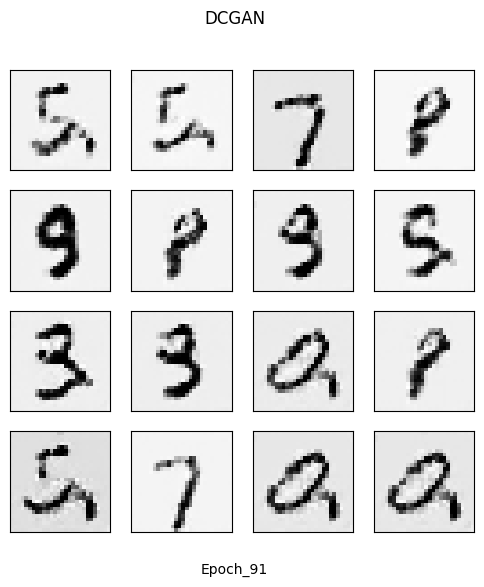

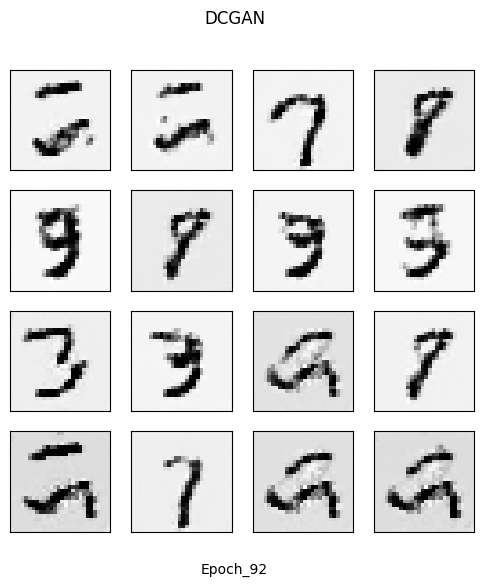

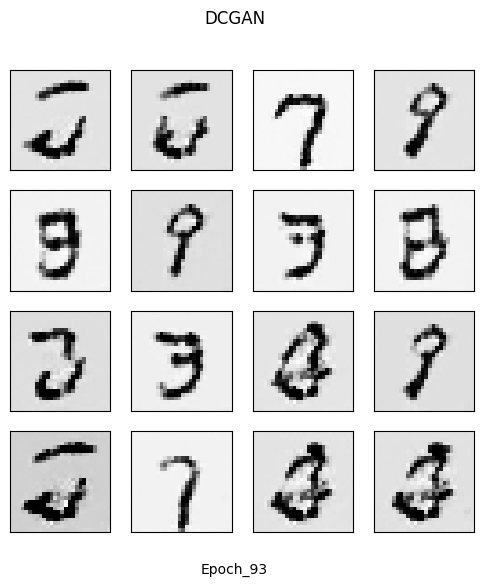

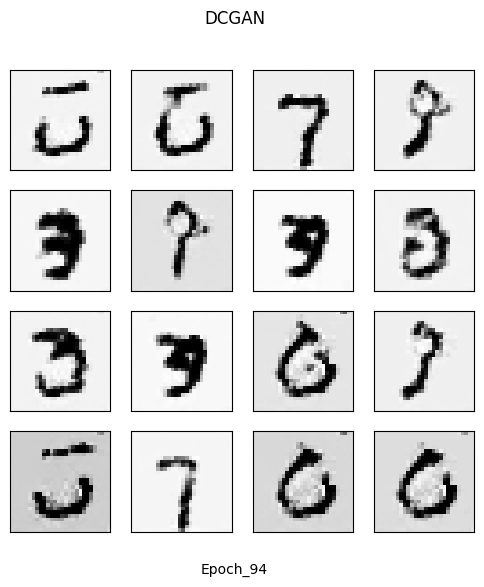

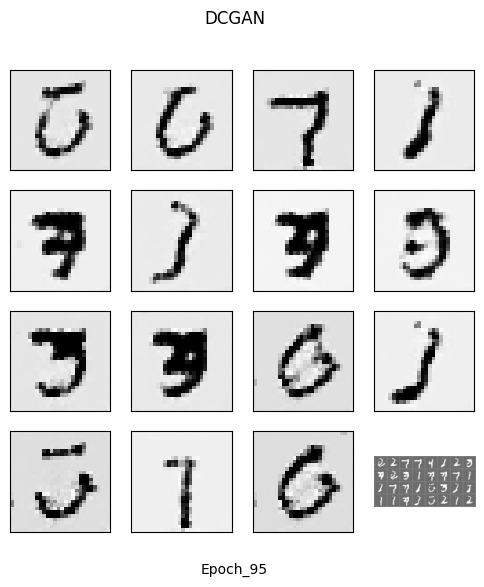


Epoch [96/100]..........	d_loss: 0.0003, g_loss: 9.3305

Epoch [97/100]..........	d_loss: 0.0050, g_loss: 8.5377

Epoch [98/100]..........	d_loss: 0.0035, g_loss: 8.2333

Epoch [99/100]..........	d_loss: 0.0015, g_loss: 8.4987

Epoch [100/100]..........	d_loss: 0.0006, g_loss: 8.5653


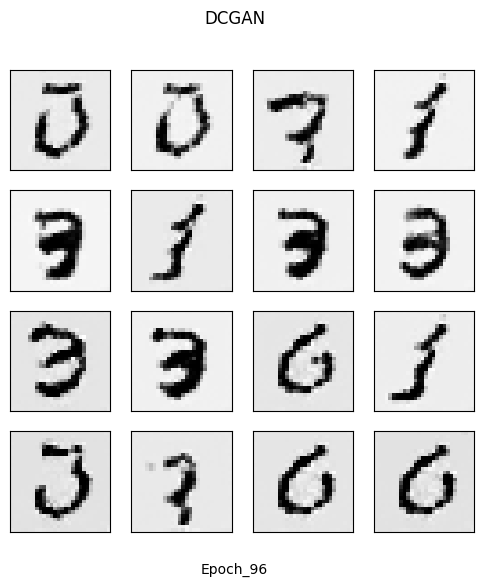

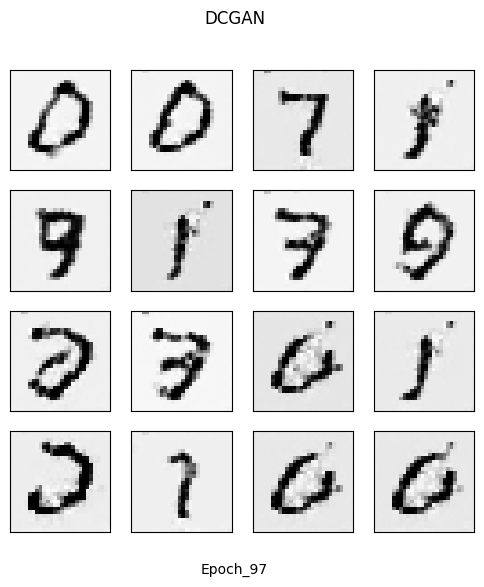

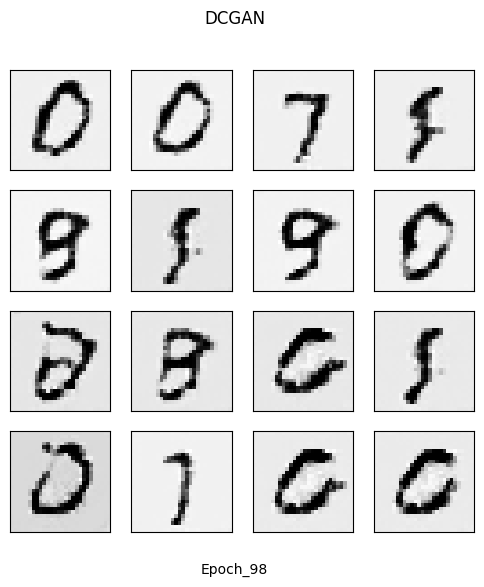

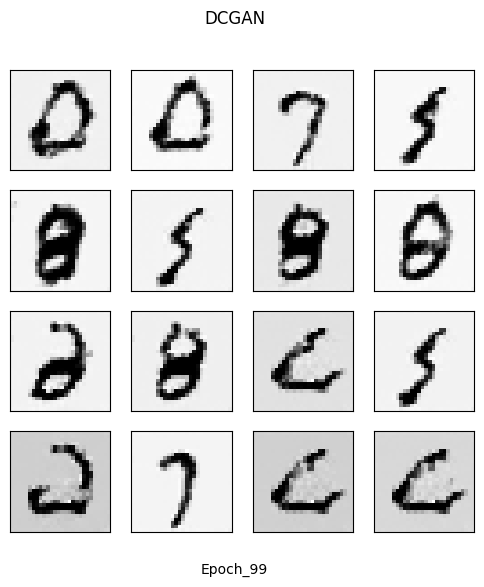

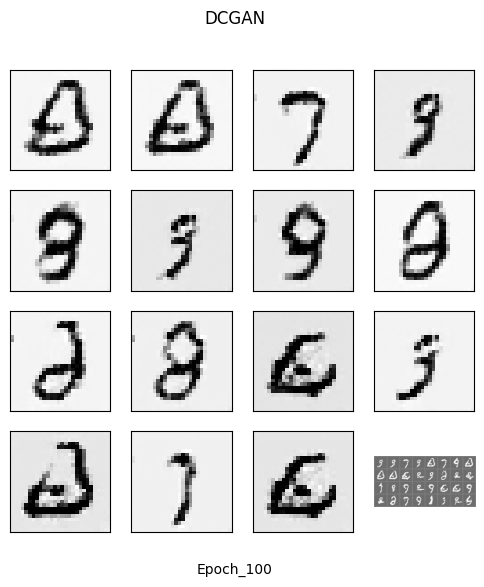

<ipython-input-35-761df8f4d00f>:61: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gif.append(imageio.imread(image))


In [43]:
netG = Generator().to(device)
netD = Discriminator().to(device)

epochs = 100
noise_dim = 100

lrG = 0.0001
lrD = 0.0001
optimizerG = torch.optim.Adam(netG.parameters(), lr=lrG)
optimizerD = torch.optim.Adam(netD.parameters(), lr=lrD)

num_batches = len(train_loader)
print_every = num_batches // 10  # Print a dot every 10% completion

real_label = 1.
fake_label = 0.

netG.train()
netD.train()


for epoch in range(epochs):
    for i, (real_images, _) in enumerate(train_loader):

      bs = real_images.shape[0]
      ##############################
      #   Training discriminator   #
      ##############################

      netD.zero_grad()
      real_images = real_images.to(device)
      label = torch.full((bs,), real_label, device=device)

      output = netD(real_images)
      lossD_real = criterion(output, label)
      lossD_real.backward()
      D_x = output.mean().item()

      noise = torch.randn(bs, 100, 1, 1, device=device)
      fake_images = netG(noise)
      label.fill_(fake_label)
      output = netD(fake_images.detach())
      lossD_fake = criterion(output, label)
      lossD_fake.backward()
      D_G_z1 = output.mean().item()
      lossD = lossD_real + lossD_fake
      optimizerD.step()

      ##########################
      #   Training generator   #
      ##########################

      netG.zero_grad()
      label.fill_(real_label)


      output = netD(fake_images)
      lossG = criterion(output, label)
      lossG.backward()
      D_G_z2 = output.mean().item()
      optimizerG.step()



      if i == 0:
        print(f"\nEpoch [{epoch+1}/{epochs}]", end='', flush=True)

      if (i + 1) % print_every == 0:
          print('.', end='', flush=True)

    print(f"\td_loss: {lossD.item():.4f}, g_loss: {lossG.item():.4f}")

    netG.eval()
    generate_images(epoch, path, fixed_noise, netG, device)
    netG.train()

    if (epoch+1) % 5 == 0:
        netG.eval()
        noise = getNoise()
        gen_imgs = netG(noise)
        visualize_mnist_grid(gen_imgs.cpu(),  num_rows=8)
        # visualize_mnist_grid(real_images.cpu(), torch.ones_like(gen_imgs).cpu(), num_rows=8)

        netG.train()

save_gif(path, 30)

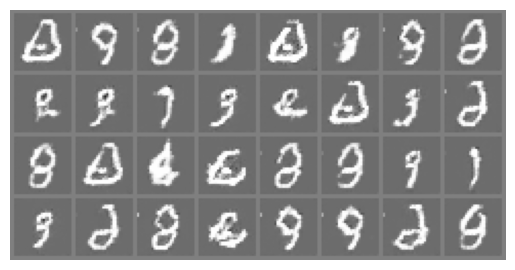

In [44]:
# noise = torch.randn((BS, noise_dim, 1, 1))
noise = getNoise()
imgs = netG(noise)

# gen_imgs = gen_model(noise)
visualize_mnist_grid(imgs.cpu(),  num_rows=8)

In [42]:
imgs[0].min(), imgs[0].max(), imgs[0].shape

(tensor(-0.5214, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.9955, device='cuda:0', grad_fn=<MaxBackward1>),
 torch.Size([1, 28, 28]))